# Posterior analysis.

After training a MLP model using PyTorch-Lightning (see `scripts/train_emu.py`), we export it to JAX, and then perform NUTS sampling with NumPyro 

The model takes in PyRSD parameters *x* as input, and outputs a 228 dimensional vector of [P0(x), P2(x), P4(x)].flatten()

Model was trained using Negative Gaussing log likelihood

### Imports and figure defaults

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# import torch

import os

from pyrsd_emu import mlp
from pyrsd_emu import data_module
from pyrsd_emu import format_figures


### Load data

In [7]:
data_path = '../data/powerspectra_11param_val.h5'
# data_path = '../data/powerspectra_sigma8_z-f-b1_cA_val.h5'

multipole_order = 3
with h5py.File(data_path, 'r') as hf:
    print(hf.keys())
    model_param_names = hf['model_param_names'][:].astype("U")
    model_params = hf['model_params'][:]

    pk = np.hstack(
            [hf[f"pk{i*2}_nonlin_convolved"][:] for i in range(multipole_order)],
        )
    pk_sig = np.hstack(
        [hf[f"pk{i*2}_sig"][:] for i in range(multipole_order)],
    )
  
    k = hf['k'][:]
    nkbins = k.shape[0]


<KeysViewHDF5 ['k', 'model_param_names', 'model_params', 'pk0_lin', 'pk0_nonlin', 'pk0_nonlin_convolved', 'pk0_r', 'pk0_r_sig', 'pk0_sig', 'pk2_lin', 'pk2_nonlin', 'pk2_nonlin_convolved', 'pk2_r', 'pk2_r_sig', 'pk2_sig', 'pk4_lin', 'pk4_nonlin', 'pk4_nonlin_convolved', 'pk4_r', 'pk4_r_sig', 'pk4_sig']>


### Load model and dataloader

In [8]:

ckpt_file_path = "../model_outputs/mlp_cosmo_to_pk_dims_256_256_256_256/epoch=99-val_loss=-7713.73.ckpt"

model_emu = mlp.MLP.load_from_checkpoint(ckpt_file_path)

dataset = data_module.PowerspectraDataset(
    model_emu.hparams['val_path'],
    model_emu.hparams['norm_path'],
    None,
    multipole_order=model_emu.hparams['multipole_order'],
)


### Convert PyTorch model to JAX

This is a bit hacky for now!

Extract weights and biases from PyTorch model and constructs a corresponding JAX model 

In [9]:
# Extract weights and biases from PyTorch model 

d = model_emu.state_dict()

# In this simple MLP model weights and biases at each layer L are denoted by 'mlp.{2*L}.weight' and 'mlp.{2*L}.bias'
pretrained_model_weights_and_b = []
for L in range(0, len(d), 2):
    pretrained_model_weights_and_b.append( [ d[f'mlp.{L}.weight'].numpy(), d[f'mlp.{L}.bias'].numpy() ] )

Text(0, 0.5, '$MLP_{PyTorch} - MLP_{JAX}$')

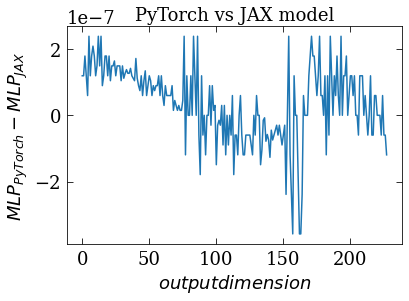

In [13]:
# Make JAX MLP model
import numpyro
numpyro.set_platform("cpu")

import torch 

import jax
import jax.numpy as jnp
import numpy as np
from jax import random, grad, jit, vmap

pretrained_model_weights_and_b 
def relu(x):
    return jnp.maximum(0, x)

def jax_model(x):
    activations = x
    for w, b in pretrained_model_weights_and_b[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = pretrained_model_weights_and_b[-1]
    out = jnp.dot(final_w, activations) + final_b
    return out

# jax_predict = vmap(jax_model, in_axes=(None, 0))

# Check that both models are equivalent to numerical precision!
x = np.random.uniform(0, 1, size=(11)).astype(np.float32)
y_pred_jax = jax_model(x)
y_pred_pytorch = model_emu(torch.tensor(x)).detach().numpy()

plt.plot(y_pred_pytorch-y_pred_jax)
plt.title("PyTorch vs JAX model")
plt.xlabel('$output dimension$')
plt.ylabel('$MLP_{PyTorch} - MLP_{JAX}$')

### Sampling

In [14]:
# Define plotting functions
import math

def plot_mcmc(samples, true_params, filename="../figures/val_fit_params.pdf"):

    # Plot PDFs and true values
    samples_norm = dataset.normalize_model_params(samples, inv=True)
    params_unnorm = dataset.normalize_model_params(true_params.flatten(), inv=True)

    useful_param_inds = [1,2,4,5,8,9,10]
    useful_param_inds = np.arange(11)

    nsamp = samples_norm.shape[0]
    samples_norm = np.sort(samples_norm, axis=0)
    med = samples_norm[nsamp//2]
    s1u = samples_norm[int(nsamp/2 + 0.341*nsamp)]
    s1d = samples_norm[int(nsamp/2 - 0.341*nsamp)]
    s2u = samples_norm[int(nsamp/2 + 0.477*nsamp)]
    s2d = samples_norm[int(nsamp/2 - 0.477*nsamp)]
    s3u = samples_norm[int(nsamp/2 + 0.498*nsamp)]
    s3d = samples_norm[int(nsamp/2 - 0.498*nsamp)]

    c = 'C0'
    nx = 4
    ny = math.ceil(len(useful_param_inds)/nx)
    fig, ax = plt.subplots(ny, nx, figsize=(nx*5,ny*3)) 
    plt.subplots_adjust(wspace=0.05, hspace=0.3)

    for iplt, iparam in enumerate(useful_param_inds):
        ix = iplt % nx
        iy = iplt // nx

        bins = np.linspace(samples_norm[:, iparam].min(), samples_norm[:, iparam].max(), 100)
        kernel = stats.gaussian_kde(samples_norm[:,iparam])

        y = kernel(bins)
        y /= y.max()

        ax[iy, ix].plot(bins, y, color=c)

        ax[iy, ix].axvline(params_unnorm[iparam], color='k', ls='-', label="True Value")

        ax[iy, ix].fill_between(bins, y,
                                where=(bins > s3d[iparam]) & (bins < s3u[iparam]), color=c, ls='-', alpha=0.2)
        ax[iy, ix].fill_between(bins, y,
                                where=(bins > s2d[iparam]) & (bins < s2u[iparam]), color=c, ls='-', alpha=0.5)

        ax[iy, ix].fill_between(bins, y,
                                where=(bins > s1d[iparam]) & (bins < s1u[iparam]), color=c, ls='-', alpha=0.7)

        ax[iy, ix].set_title(model_param_names[iparam])

        ax[iy, ix].legend(fontsize=12, loc='upper right', frameon=False)

        ax[iy, ix].set_ylim(0.0, 1.0)
        ax[iy, ix].get_yaxis().set_ticks([])

    plt.savefig(filename, bbox_inches='tight')

### Define NumPyro sampler

In [15]:
import numpyro
from numpyro.infer import MCMC, NUTS, HMC
import numpyro.distributions as dist
from jax import random, grad, jit, vmap
import scipy.stats as stats
import math

def numpyro_model(y, y_sig):
    with numpyro.plate("data", y.shape[0]):
        x_ini = numpyro.sample('pyrsd_params', dist.Uniform(np.zeros(11), np.ones(11)))
        y_pred = jax_model(x_ini)
        numpyro.sample('obs', dist.Normal(y_pred, y_sig), obs=y)



### Sample some posteriors belonging to data from validation set 

CPU only for now - GPU to come

In [ ]:
print(jax.local_device_count())

nfit = 1 # Number of validation samples to fit

params = {}
params['num_samples'] = 5000
params['num_chains'] = 1
params['num_warmup'] = 5000
params['num_steps'] = 3
params['jit'] = False

# "useful" parameters only (some in this model have no effect on the output.. investigating why)
useful_param_inds = [1,2,4,5,8,9,10]
    
for i in range(nfit):
    x, y, y_sig = dataset.__getitem__(i)
    x, y, y_sig = x[None, :], y[None, :], y_sig[None, :]
    # y, y_sig, x = torch.tensor(y), torch.tensor(y_sig), torch.tensor(x)
    # y, y_sig, x = torch.tensor(y[None, :]).cuda(), torch.tensor(y_sig[None, :]).cuda(), torch.tensor(x[None, :]).cuda()

    # HMC is having trouble, and convergence seems to be strongly dependent on hyperparameters
    # hmc_kernel = HMC(numpyro_model, num_steps=params['num_steps'],
    #                  adapt_mass_matrix=True, adapt_step_size=True, trajectory_length=0.5)
    
    # Kernel
    hmc_kernel = NUTS(numpyro_model)

    # Sampler
    mcmc = MCMC(
        hmc_kernel,
        num_samples=params['num_samples'],
        num_warmup=params['num_warmup'],
        num_chains=params['num_chains'],
    )
    
    # Run
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, y, y_sig)
    # mcmc.get_samples()['pyrsd_params']#.mean(0)  


    
    # Print chain summary
    mcmc.print_summary()

    bins = np.linspace(0, 1, 100)
    samples = mcmc.get_samples()['pyrsd_params']

    # Plot chains
    nx = 4
    ny = math.ceil(samples.shape[1]/nx)
    fig, ax = plt.subplots(ny, nx, figsize=(4*nx,2*ny))
    plt.subplots_adjust(hspace=0.3, wspace=0.4)
    for iparam in range(samples.shape[1]):
        ix = iparam % nx
        iy = iparam // nx
        ax[iy, ix].plot(samples[:, iparam])
        ax[iy, ix].set_ylabel(f"x_{iparam}")
        ax[iy, ix].set_xlabel(f"sample")

    # Plot PDFs and true values
    plot_mcmc(samples, x, filename=f"../figures/val_fit_params_{i:02d}.pdf")


1


warmup:  35%|███▍      | 3472/10000 [00:59<02:19, 46.86it/s, 511 steps of size 9.05e-03. acc. prob=0.79] 

# Fit real or mock data

(1, 228)


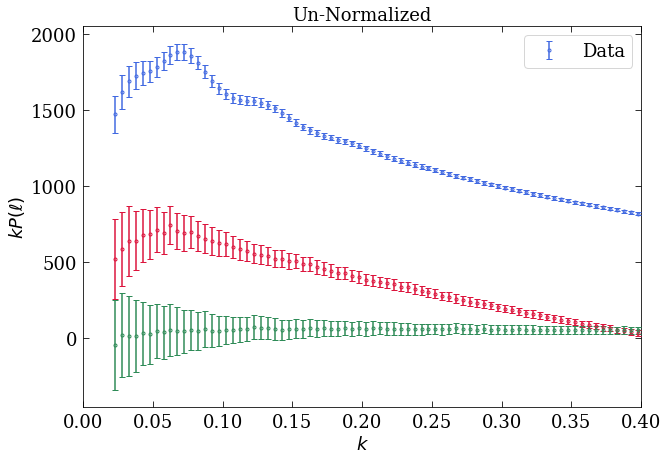

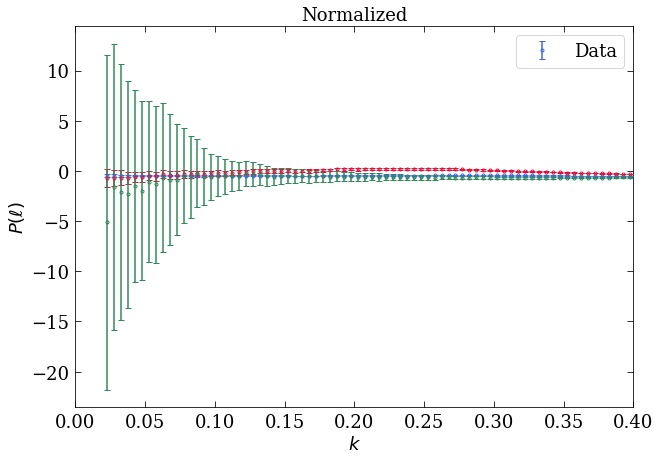

In [48]:
# Load the data
data = np.load('../data/Pell_avgmock1000.npz')

var_fac = np.sqrt(1000)
data.files
k = data['k']
P0, P2, P4 = data['P0'], data['P2'], data['P4']
P0_err, P2_err, P4_err = data['P0_err']*var_fac, data['P2_err']*var_fac, data['P4_err']*var_fac

pk = np.concatenate([P0, P2, P4])[None, :]
pk_err = np.concatenate([P0_err, P2_err, P4_err])[None, :]

pk_norm = dataset.normalize_pk(pk)
pk_err_norm = dataset.normalize_pk(pk_err, use_mean=False)

# Plot the data
plt.figure(figsize=(10,7))

plt.errorbar(k, k*P0, yerr = k*P0_err, fmt='.', mfc='None', mec='royalblue', ecolor = 'royalblue', capsize = 3.0, label = 'Data', zorder=10)
plt.errorbar(k, k*P2, yerr = k*P2_err, fmt='.', mfc='None', mec='crimson', ecolor = 'crimson', capsize = 3.0, label = None, zorder=10)
plt.errorbar(k, k*P4, yerr = k*P4_err, fmt='.', mfc='None', mec='seagreen', ecolor = 'seagreen', capsize = 3.0, label = None, zorder=10)

plt.xlim(0, 0.4)
# plt.yscale('log')
plt.legend()
plt.title("Un-Normalized")
plt.ylabel("$k P(\ell)$")
plt.xlabel("$k$")
# Plot normalized data
plt.figure(figsize=(10,7))

plt.errorbar(k, pk_norm.reshape(3, -1)[0], yerr = pk_err_norm.reshape(3, -1)[0], fmt='.', mfc='None', mec='royalblue', ecolor = 'royalblue', capsize = 3.0, label = 'Data', zorder=10)
plt.errorbar(k, pk_norm.reshape(3, -1)[1], yerr = pk_err_norm.reshape(3, -1)[1], fmt='.', mfc='None', mec='crimson', ecolor = 'crimson', capsize = 3.0, label = None, zorder=10)
plt.errorbar(k, pk_norm.reshape(3, -1)[2], yerr = pk_err_norm.reshape(3, -1)[2], fmt='.', mfc='None', mec='seagreen', ecolor = 'seagreen', capsize = 3.0, label = None, zorder=10)

plt.xlim(0, 0.4)
# plt.yscale('log')
plt.legend()
plt.title("Normalized")
plt.ylabel("$P(\ell)$")
plt.xlabel("$k$")
print(pk.shape)

/tmp/ipykernel_249597/1345798447.py:30: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 50000/50000 [06:31<00:00, 127.63it/s, 255 steps of size 1.26e-02. acc. prob=0.86] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 pyrsd_params[0]      0.52      0.29      0.53      0.10      1.00  28394.31      1.00
 pyrsd_params[1]      0.29      0.05      0.28      0.21      0.37   6838.94      1.00
 pyrsd_params[2]      0.18      0.06      0.17      0.08      0.27  11919.46      1.00
 pyrsd_params[3]      0.50      0.28      0.50      0.11      0.99  29203.53      1.00
 pyrsd_params[4]      0.29      0.08      0.26      0.19      0.42   2603.85      1.00
 pyrsd_params[5]      0.57      0.35      0.65      0.08      1.00   2491.22      1.00
 pyrsd_params[6]      0.52      0.29      0.53      0.11      1.00  28790.26      1.00
 pyrsd_params[7]      0.58      0.28      0.61      0.16      1.00  24462.30      1.00
 pyrsd_params[8]      0.58      0.08      0.59      0.46      0.71   7281.19      1.00
 pyrsd_params[9]      0.51      0.03      0.50      0.46      0.56   4717.59      1.00
pyrsd_params[10]      0.26      0.29      

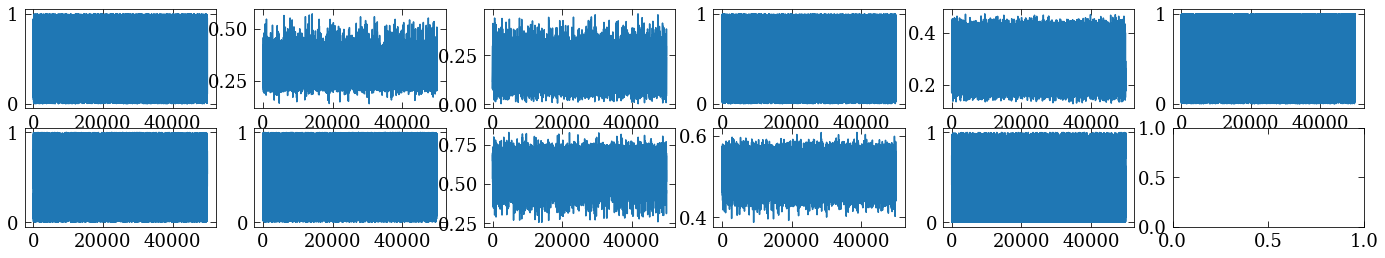

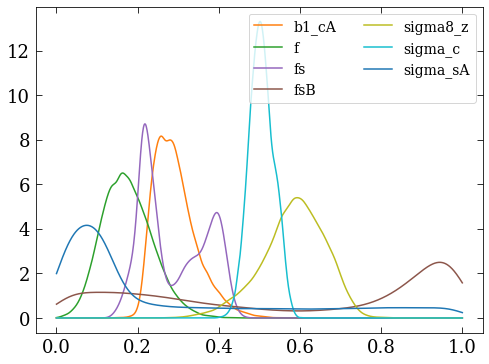

In [57]:
import numpyro
from numpyro.infer import MCMC, NUTS, HMC
import numpyro.distributions as dist
from jax import random, grad, jit, vmap
import scipy.stats as stats
import math

def numpyro_model(y, y_sig):
    with numpyro.plate("data", y.shape[0]):
        x_ini = numpyro.sample('pyrsd_params', dist.Uniform(np.zeros(11), np.ones(11)))
        y_pred = jax_model(x_ini)
        numpyro.sample('obs', dist.Normal(y_pred, y_sig), obs=y)

def run_mcmc(params, ind=0, x=None, y=None, y_sig=None, seed=0):
    """
    x: network input parameters
    y: data
    y_sig: data_uncertainty
    """
#     if y is None:
#         x, y, y_sig = dataset.__getitem__(ind)
#         x, y, y_sig = x[None, :], y[None, :], y_sig[None, :]

#         print(y.shape, y_sig.shape, x.shape)


    # hmc_kernel = HMC(numpyro_model, num_steps=params['num_steps'])
    hmc_kernel = NUTS(numpyro_model)

    mcmc = MCMC(
        hmc_kernel,
        num_samples=params['num_samples'],
        num_warmup=params['num_warmup'],
        num_chains=params['num_chains'],
    )
    rng_key = random.PRNGKey(seed)
    
    mcmc.run(rng_key, y, y_sig)
    # mcmc.get_samples()['pyrsd_params']#.mean(0)  

    mcmc.print_summary()

    return mcmc

def plot_mcmc(mcmc, x=None, useful_param_inds=[1,2,4,5,8,9,10]):
    
    bins = np.linspace(0, 1, 1000)
    samples = mcmc.get_samples()['pyrsd_params']

    # Plot chains
    nx = 6
    ny = math.ceil(samples.shape[1]/nx)
    fig, ax = plt.subplots(ny, nx, figsize=(4*nx,2*ny))
    for iparam in range(samples.shape[1]):
        ix = iparam % nx
        iy = iparam // nx
        print(ix, iy)
        ax[iy, ix].plot(samples[:,iparam])

    # Plot PDFs and true values
    plt.figure()
    for iparam in range(samples.shape[1]):
        if iparam not in useful_param_inds:
            continue
        kernel = stats.gaussian_kde(samples[:,iparam])
        c = f'C{iparam%10}'
        plt.plot(bins, kernel(bins), color=c, label=model_param_names[iparam])
        if x:
            plt.axvline(x[0, iparam], color=c, ls=':')
    plt.legend(ncol=2, fontsize=14)
   
params = {}
params['num_samples'] = 25000
params['num_chains'] = 2
params['num_warmup'] = 25000
params['num_steps'] = 4
params['jit'] = False

for i in range(1):
    
    # x, y, y_sig = dataset.__getitem__(ind)
    # x, y, y_sig = x[None, :], y[None, :], y_sig[None, :]
    # print(y.shape, y_sig.shape, x.shape)

    mcmc = run_mcmc(params, y=pk_norm, y_sig=pk_err_norm, seed=13579)

    plot_mcmc(mcmc)
    
    



In [71]:
samples = mcmc.get_samples()['pyrsd_params']
samples.shape

(50000, 11)

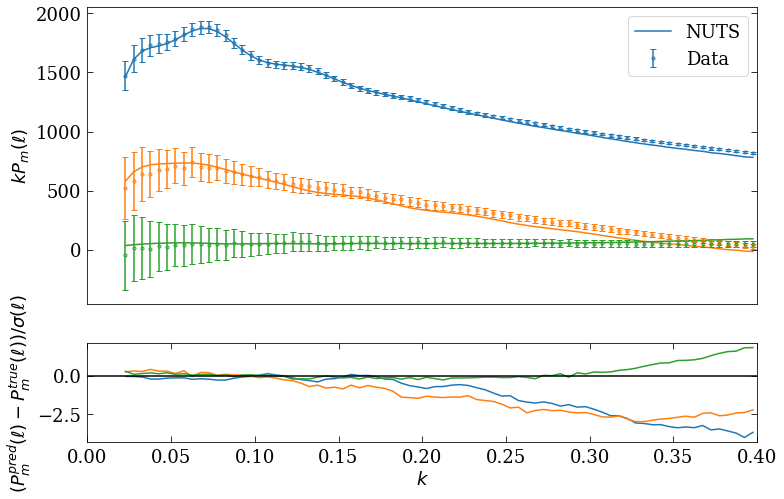

In [61]:
samples = mcmc.get_samples()['pyrsd_params']

x_mcmc = np.mean(samples, axis=0)
x_std_mcmc = np.std(samples, axis=0)

pk_pred_norm = jax_model(x_mcmc)
pk_pred_norm_1u = jax_model(x_mcmc+x_std_mcmc)
pk_pred_norm_1d = jax_model(x_mcmc-x_std_mcmc)

pk_pred = dataset.normalize_pk(pk_pred_norm, inv=True)
pk_pred_1u = dataset.normalize_pk(pk_pred_norm_1u, inv=True)
pk_pred_1d = dataset.normalize_pk(pk_pred_norm_1d, inv=True)

fig, ax = plt.subplots(2, 1, figsize=(12,8),
                       gridspec_kw={'height_ratios': [3, 1]})

for m in range(3):
    
    c = f"C{m%10}"
    
    ax[0].errorbar(k, k*pk.reshape(3, -1)[m], yerr=k*pk_err.reshape(3, -1)[m], fmt='.', mfc='None', capsize=3.0, mec=c, ecolor=c, label='Data' if m==0 else None)
    ax[0].plot(k, k*pk_pred.reshape(3, -1)[m], color=c, label='NUTS' if m==0 else None) 
    
    ax[1].plot(k, (pk_pred.reshape(3, -1)[m] - pk.reshape(3, -1)[m])/pk_err.reshape(3, -1)[m], color=c)
        
    # plt.plot(k, k*pk_pred_1u.reshape(3, -1)[m], color=c, ls='--', label='$+1\sigma$' if m==0 else None) 
    # plt.plot(k, k*pk_pred_1d.reshape(3, -1)[m], color=c, ls=':', label='$-1\sigma$' if m==0 else None) 
    
    # ax[m].set_title(f"$P_{m*2}(\ell)$")


ax[1].axhline(color='k')
# plt.yscale('log')
ax[0].legend()

ax[0].set_xlim(0, 0.4)
ax[1].set_xlim(0, 0.4)

ax[0].set_ylabel(f"$k P_m(\ell)$")

ax[1].set_xlabel("$k$")
ax[1].set_ylabel("$(P^{pred}_m(\ell) - P^{true}_m(\ell)) / \sigma (\ell)$")

ax[0].get_xaxis().set_ticks([])


# Plot normalized data

# fig, ax = plt.subplots(3, 1, figsize=(8,8))

# for m in range(3):
#     c = f"C{m%10}"
#     ax[m].errorbar(k, k*pk.reshape(3, -1)[m], yerr=k*pk_err.reshape(3, -1)[m], fmt='.', mfc='None', capsize=3.0, mec=c, ecolor=c, label='Data' if m==0 else None)
#     ax[m].plot(k, k*pk_pred.reshape(3, -1)[m], color=c, label='NUTS' if m==0 else None) 
#     # plt.plot(k, k*pk_pred_1u.reshape(3, -1)[m], color=c, ls='--', label='$+1\sigma$' if m==0 else None) 
#     # plt.plot(k, k*pk_pred_1d.reshape(3, -1)[m], color=c, ls=':', label='$-1\sigma$' if m==0 else None) 
    
#     # ax[m].set_title(f"$P_{m*2}(\ell)$")

#     ax[m].set_xlim(0, 0.4)
#     ax[m].set_ylabel(f"$k P_{m*2}(\ell)$")

# # plt.yscale('log')
# ax[0].legend()

# ax[2].set_xlabel("$k$")

# ax[0].get_xaxis().set_ticks([])

plt.savefig("../figures/data_fit_powerspectra.pdf", bbox_inches='tight')

In [51]:
import matplotlib.gridspec as gridspec
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import pearsonr
import matplotlib.patheffects as pe

# cmap = plt.cm.cividis
def plot_grid(data, labels=None, errs=None, 
              color_arr=None, color_label=None, color_symmetric=False,
              plot_density=False, plot_diagonal=False,
              xyminmax=None,
              figsize=(8,8), spacing=0.05, s=30, ms_mean=6, alpha=1.0, cmap=plt.cm.viridis, markeredgecolor='k',
              savefig=False, filename='plot_grid.pdf', rasterized=False, include_mean=False, nbins=25, nbins_contour=15,
             show_correlation=True, fontsize=12):
    
    """plot variables against each other. Similar to seaborns pairplot, but more functionality"""
    
    # colors = plt.cm.coolwarm_r(np.linspace(0.6, 1.0, 256))
    # colors[0:4, :3] = 1.
    # colors_1D = colors[int(0.8*colors.shape[0])]
    colors = cmap(np.linspace(0.0, 1.0, 256))
    colors_1D = cmap(0.8)
    print(colors_1D)
    # cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

    sigmas = np.array([1., 2.])#, 3.]) # sigmas
    colors_contour = plt.cm.coolwarm(np.linspace(0.6, 1.0, 256))
    # contour_colors = colors_contour[ np.linspace(0, colors_contour.shape[0]-1, sigmas.shape[0]).astype(int) ]
    contour_colors = np.zeros((len(sigmas), 4))
    contour_colors[:, -1] = np.linspace(0.2, 0.7, contour_colors.shape[0])

    nx = data.shape[1] - 1
    ny = data.shape[1] - 1
    istart = 1
    jstart = 1
    
    if plot_density:
        plot_diagonal=True
    if not plot_diagonal:
        istart = 0
        jstart = 0

    if color_arr is None:
        color_arr_plt = color_arr
    else:
        color_arr_plt = color_arr.copy()

    if color_symmetric:
        # cminmax = min(np.abs(np.min(color_arr_plt)), np.abs(np.max(color_arr_plt)))
        cminmax = 0.25
        color_arr_plt[color_arr_plt < -cminmax] = -cminmax
        color_arr_plt[color_arr_plt > cminmax] = cminmax

    if labels is None:
        labels = ['z_{:d}'.format(i) for i in range(data.shape[1])]
        
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=ny+jstart, nrows=nx+istart, figure=fig)

    plt.subplots_adjust(wspace=spacing, hspace=spacing)

    if cmap is None:
        cmap = plt.cm.viridis
       
    if plot_diagonal:
        for i in range(data.shape[1]):
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[i, i])
            ax.hist(data[:, jj].flatten(), histtype='step', 
                    lw=2, 
                    bins=nbins, 
                    color=colors_1D)
            
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')
            
            ax.set_yticklabels([])
            ax.set_yticks([])
            if i == data.shape[1] - 1:
                ax.set_xlim(data[:, jj].min(), data[:, jj].max() )
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=30)

            if i < data.shape[1] - 1:
                ax.set_xticklabels([])
                      
    for i in range(nx):
        for j in range(i, ny):
            
            ii = ny-j 
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[j+jstart, i])
            if color_arr_plt is not None:
                if i==0 and j==0:
                    xx = np.linspace(color_arr_plt.min(), color_arr_plt.max(), 256)
                    dummie_cax = ax.scatter(xx, xx, c=xx, cmap=cmap)
                    # Clear axis
                    ax.cla()

            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

            if i == 0:
                ax.set_ylabel(labels[ii])
            else:
                ax.set_yticklabels([])
            
            if j == ny-1:
                ax.set_xlabel(labels[jj])
            else:
                ax.set_xticklabels([])

            if not plot_density:
                if color_arr_plt is None:
                    if errs is None:
                        ax.scatter(data[:, jj], data[:, ii], s=s, alpha=alpha, rasterized=rasterized)
                    else:
                        ax.errorbar(data[:, jj], data[:, ii], xerr=errs[:, jj], yerr=errs[:, ii], marker='o', 
                                    ms=s, alpha=alpha, markeredgecolor=markeredgecolor,
                                    rasterized=rasterized, ls='none')

                else:
                    if errs is None:
                        c = ax.scatter(data[:, jj], data[:, ii], s=s, c=color_arr_plt, edgecolors='k', lw=0.25, alpha=alpha, cmap=cmap, rasterized=rasterized)
                        if include_mean:
                            ax.errorbar(np.mean(data[:, jj]), np.mean(data[:, ii]), xerr=np.std(data[:, jj]), yerr=np.std(data[:, ii]),
                                       ms=ms_mean, marker='o', markeredgecolor='k',
                                       color='w', lw=2, alpha=alpha)

                    else:
                        carr = (color_arr_plt-color_arr_plt.min())/(color_arr_plt.max()-color_arr_plt.min())
                        for ierr in range(data[:, jj].shape[0]):
                            ax.errorbar(data[ierr, jj], data[ierr, ii], xerr=errs[ierr, jj], yerr=errs[ierr, ii], markeredgecolor=markeredgecolor,
                                        color=cmap(carr[ierr]), marker='o', ms=s, alpha=alpha, rasterized=rasterized, ls='none', 
                                         lw=2)
                if show_correlation:
                    r, _ = pearsonr(data[:, jj], data[:, ii])
                    ax.text(0.96, 0.96, f"r={r:.2f}",
                            horizontalalignment='right',
                            verticalalignment='top',
                            transform=ax.transAxes,
                            path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()],
                           fontsize=fontsize)

            if plot_density:
                ax.hexbin(data[:, jj], data[:, ii], gridsize=nbins, cmap=cmap)#, norm=matplotlib.colors.LogNorm())
                # ax.contour(counts)#, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
                           # linewidths=3)
                H, xedges, yedges = np.histogram2d(data[:, jj], data[:, ii], bins=nbins_contour)#, bins=(xedges, yedges))

                H /= H.sum()

                n = 10000
                t = np.linspace(0, H.max(), n)
                integral = ((H >= t[:, None, None]) * H).sum(axis=(1,2))

                intervals = (1 - np.exp(-(sigmas)**2/2)) # CDF in 2D

                f = interpolate.interp1d(integral, t)
                t_contours = f(intervals[::-1])
                ax.contour(H.T, t_contours, 
                           extent=[data[:, jj].min(), data[:,jj].max(), data[:,ii].min(), data[:,ii].max()],
                          colors=contour_colors)
                if include_mean:
                        ax.errorbar(np.mean(data[:, jj]), np.mean(data[:, ii]), xerr=np.std(data[:, jj]), yerr=np.std(data[:, ii]),
                                    ms=ms_mean, marker='o', markeredgecolor='w',
                                    color='k', lw=2, alpha=alpha)
                        
            if xyminmax is not None:
                ax.set_ylim(xyminmax[ii])
                ax.set_xlim(xyminmax[jj])
            # else:
            #     ax.set_ylim(data[:, ii].min(), data[:, ii].max() )
            #     ax.set_xlim(data[:, jj].min(), data[:, jj].max() )
                
            if j == ny-1:
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=30)

            if i == 0:
                xti = ax.get_yticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_yticklabels(xti)
                
    if color_arr_plt is not None:
        cax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
        fig.colorbar(dummie_cax, cax=cax, label=color_label)

    if savefig:
        plt.savefig(filename, bbox_inches='tight')
  


(0.09019607843137256, 0.39294117647058824, 0.6705882352941177, 1.0)


/tmp/ipykernel_249597/97610692.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)
/tmp/ipykernel_249597/97610692.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
/tmp/ipykernel_249597/97610692.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
/tmp/ipykernel_249597/97610692.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
/tmp/ipykernel_249597/97610692.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
/tmp/ipykernel_249597/97610692.py:194: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
/tmp/ipykernel_249597/97610692.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation

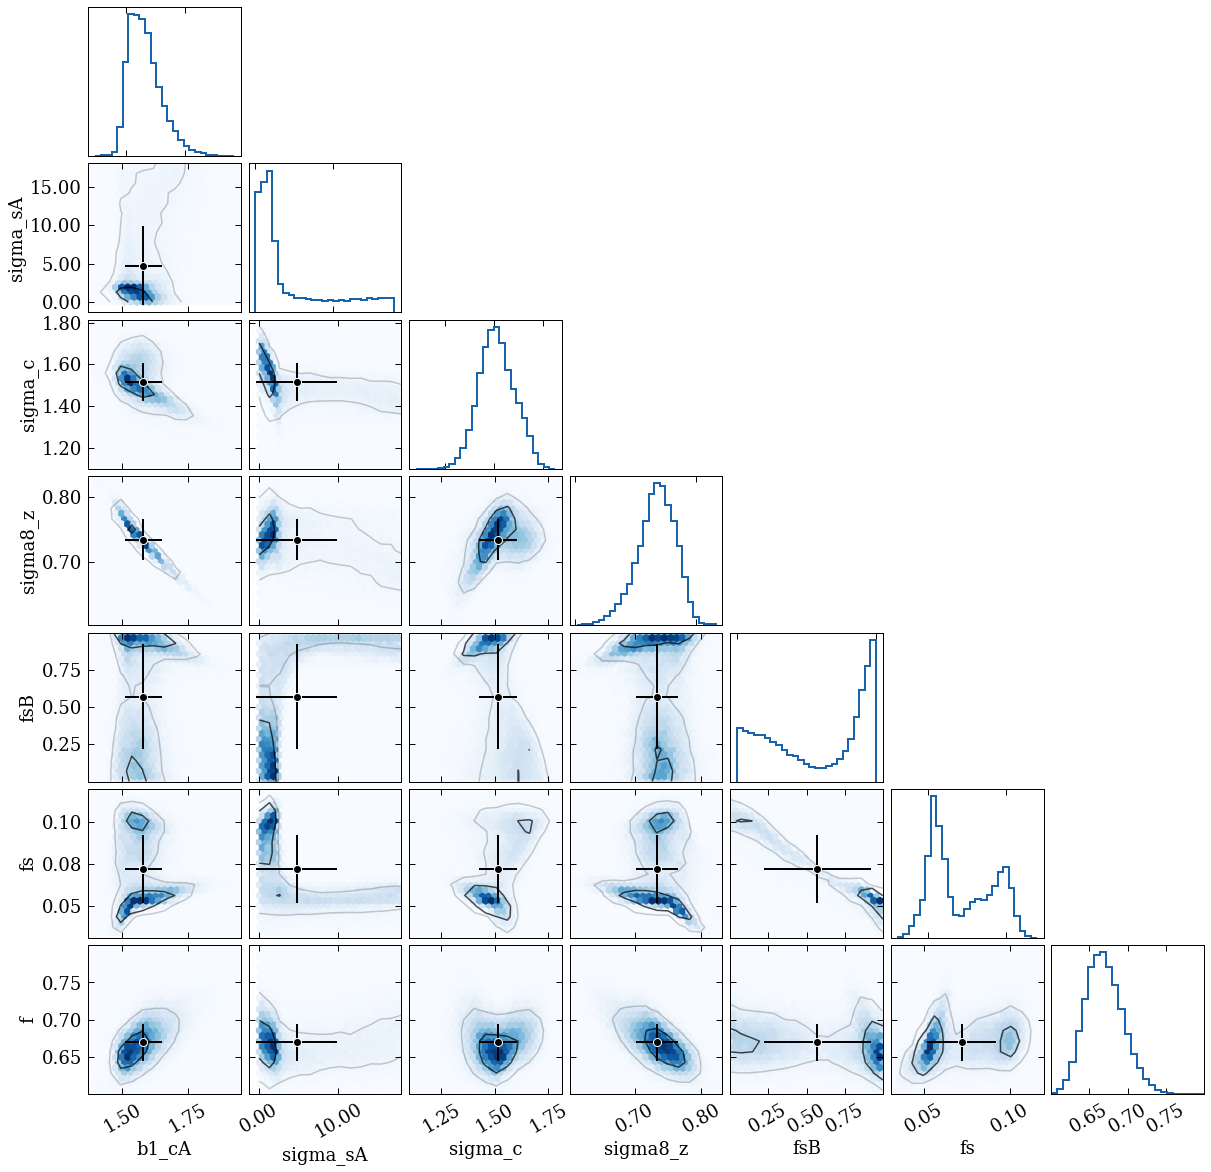

In [52]:
useful_param_inds=[1,2,4,5,8,9,10]

samples_plot = np.array(mcmc.get_samples()['pyrsd_params'])
samples_plot = dataset.normalize_model_params(samples_plot, inv=True)[:, useful_param_inds]
savefig = True
plot_grid(samples_plot, 
              labels=model_param_names[useful_param_inds], 
              figsize=(20,20),  s=10, include_mean=True, ms_mean=8,
              plot_density=True, savefig=savefig, filename='../figures/pyrsd_fit_data_paramgrid.pdf',
             cmap=plt.cm.Blues)


# Compare to pyrsd fits

In [62]:
# Sample new model parameters from prior
def sample_params_from_priors(params: dict):
    """
    params is a dictionary with parameter name as key, and prior/prior_vals as items
    """
    sample = {}
    for k in params:
        if params[k]['prior'] == 'uniform':
            lower, upper = params[k]['prior_vals']
            val = np.random.uniform(lower, upper)
        if params[k]['prior'] == 'normal':
            mu, sig = params[k]['prior_vals']
            val = np.random.normal(mu, sig)
                       
        sample[k] = val
        
    return sample

param_priors = {'Nsat_mult': {'value': 2.4040909618597026,
  'prior': 'normal',
  'prior_vals': [2.4, 0.2]},
 'b1_cA': {'value': 1.5657029077250786,
  'prior': 'uniform',
  'prior_vals': [1.2, 2.5]},
 'f': {'value': 0.6527528891436477,
  'prior': 'uniform',
  'prior_vals': [0.6, 1.0]},
 'f1h_sBsB': {'value': 3.9238303370686025,
  'prior': 'normal',
  'prior_vals': [4.0, 1.0]},
 'fs': {'value': 0.051620638641754035,
  'prior': 'uniform',
  'prior_vals': [0.0, 0.25]},
 'fsB': {'value': 0.979723456922603,
  'prior': 'uniform',
  'prior_vals': [0.0, 1.0]},
 'gamma_b1sA': {'value': 1.4586847999857098,
  'prior': 'normal',
  'prior_vals': [1.45, 0.3]},
 'gamma_b1sB': {'value': 2.10462268759816,
  'prior': 'normal',
  'prior_vals': [2.05, 0.3]},
 'sigma8_z': {'value': 0.7381751882968806,
  'prior': 'uniform',
  'prior_vals': [0.5, 0.9]},
 'sigma_c': {'value': 1.4745426397353925,
  'prior': 'uniform',
  'prior_vals': [0.0, 3.0]},
 'sigma_sA': {'value': 1.2742081601473432,
  'prior': 'uniform',
  'prior_vals': [0.0, 18.0]}}

param_priors[model_param_names[0]]

{'value': 2.4040909618597026, 'prior': 'normal', 'prior_vals': [2.4, 0.2]}

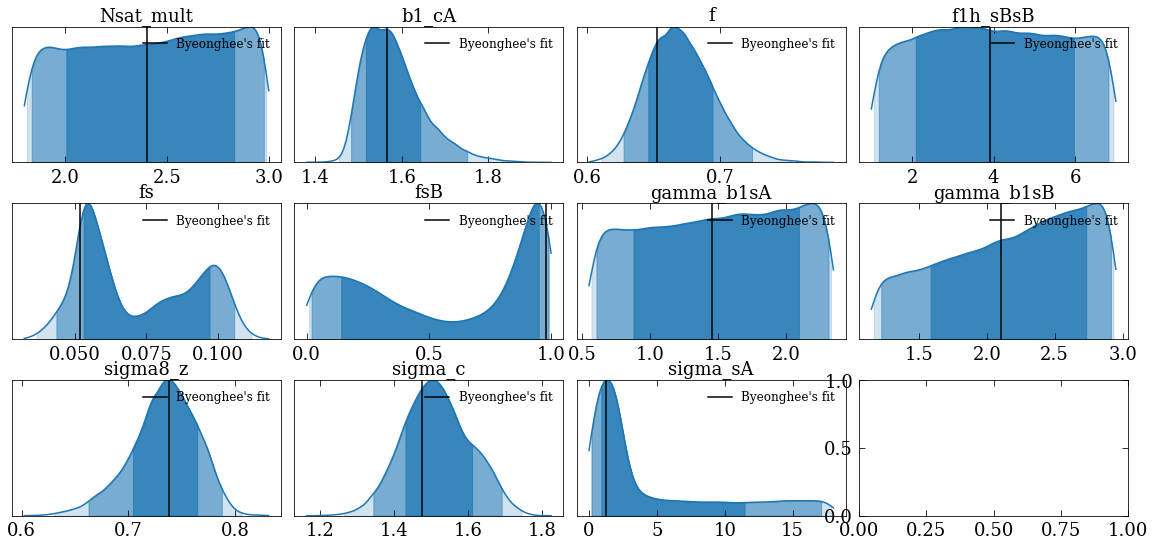

In [63]:
# Plot PDFs and true values
import math

samples_norm = dataset.normalize_model_params(samples, inv=True)
# useful_param_inds = [1,2,4,5,8,9,10]
useful_param_inds = np.arange(11)

nsamp = samples_norm.shape[0]
samples_norm = np.sort(samples_norm, axis=0)
med = samples_norm[nsamp//2]
s1u = samples_norm[int(nsamp/2 + 0.341*nsamp)]
s1d = samples_norm[int(nsamp/2 - 0.341*nsamp)]
s2u = samples_norm[int(nsamp/2 + 0.477*nsamp)]
s2d = samples_norm[int(nsamp/2 - 0.477*nsamp)]
s3u = samples_norm[int(nsamp/2 + 0.498*nsamp)]
s3d = samples_norm[int(nsamp/2 - 0.498*nsamp)]

c = 'C0'
nx = 4
ny = math.ceil(len(useful_param_inds)/nx)
fig, ax = plt.subplots(ny, nx, figsize=(nx*5,ny*3)) 
plt.subplots_adjust(wspace=0.05, hspace=0.3)

for iplt, iparam in enumerate(useful_param_inds):
    ix = iplt % nx
    iy = iplt // nx
    
    bins = np.linspace(samples_norm[:, iparam].min(), samples_norm[:, iparam].max(), 100)
    kernel = stats.gaussian_kde(samples_norm[:,iparam])
    
    y = kernel(bins)
    y /= y.max()
    
    ax[iy, ix].plot(bins, y, color=c)
    
    ax[iy, ix].axvline(param_priors[model_param_names[iparam]]['value'], color='k', ls='-', label="Byeonghee's fit")

    ax[iy, ix].fill_between(bins, y,
                            where=(bins > s3d[iparam]) & (bins < s3u[iparam]), color=c, ls='-', alpha=0.2)
    ax[iy, ix].fill_between(bins, y,
                            where=(bins > s2d[iparam]) & (bins < s2u[iparam]), color=c, ls='-', alpha=0.5)
        
    ax[iy, ix].fill_between(bins, y,
                            where=(bins > s1d[iparam]) & (bins < s1u[iparam]), color=c, ls='-', alpha=0.7)
        
    ax[iy, ix].set_title(model_param_names[iparam])
    
    ax[iy, ix].legend(fontsize=12, loc='upper right', frameon=False)
    
    ax[iy, ix].set_ylim(0.0, 1.0)
    ax[iy, ix].get_yaxis().set_ticks([])

# plt.legend(ncol=2, fontsize=14)

# plt.savefig("../figures/data_fit_params_all.pdf", bbox_inches='tight')

# Old code and trials below. Probably doesn't work anymore!

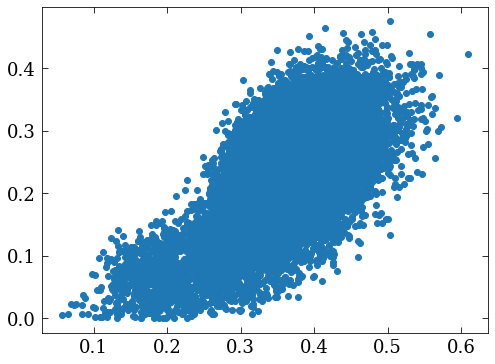

In [93]:
plt.scatter(samples[:,1], samples[:,2])

(100000,)


DeviceArray([0.3183998 , 0.2860313 , 0.315122  , ..., 0.36262962,
             0.36814123, 0.3489111 ], dtype=float32)

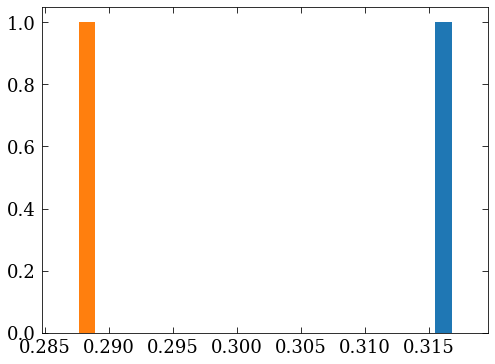

In [98]:
x = np.random.uniform(size=100000)
print(x.shape)
plt.hist(samples[:2,1])
samples[:,1]

In [100]:
np.array(samples[:2,1])

array([0.3183998, 0.2860313], dtype=float32)

/global/homes/g/gstein/.conda/envs/pyrsd_emu/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


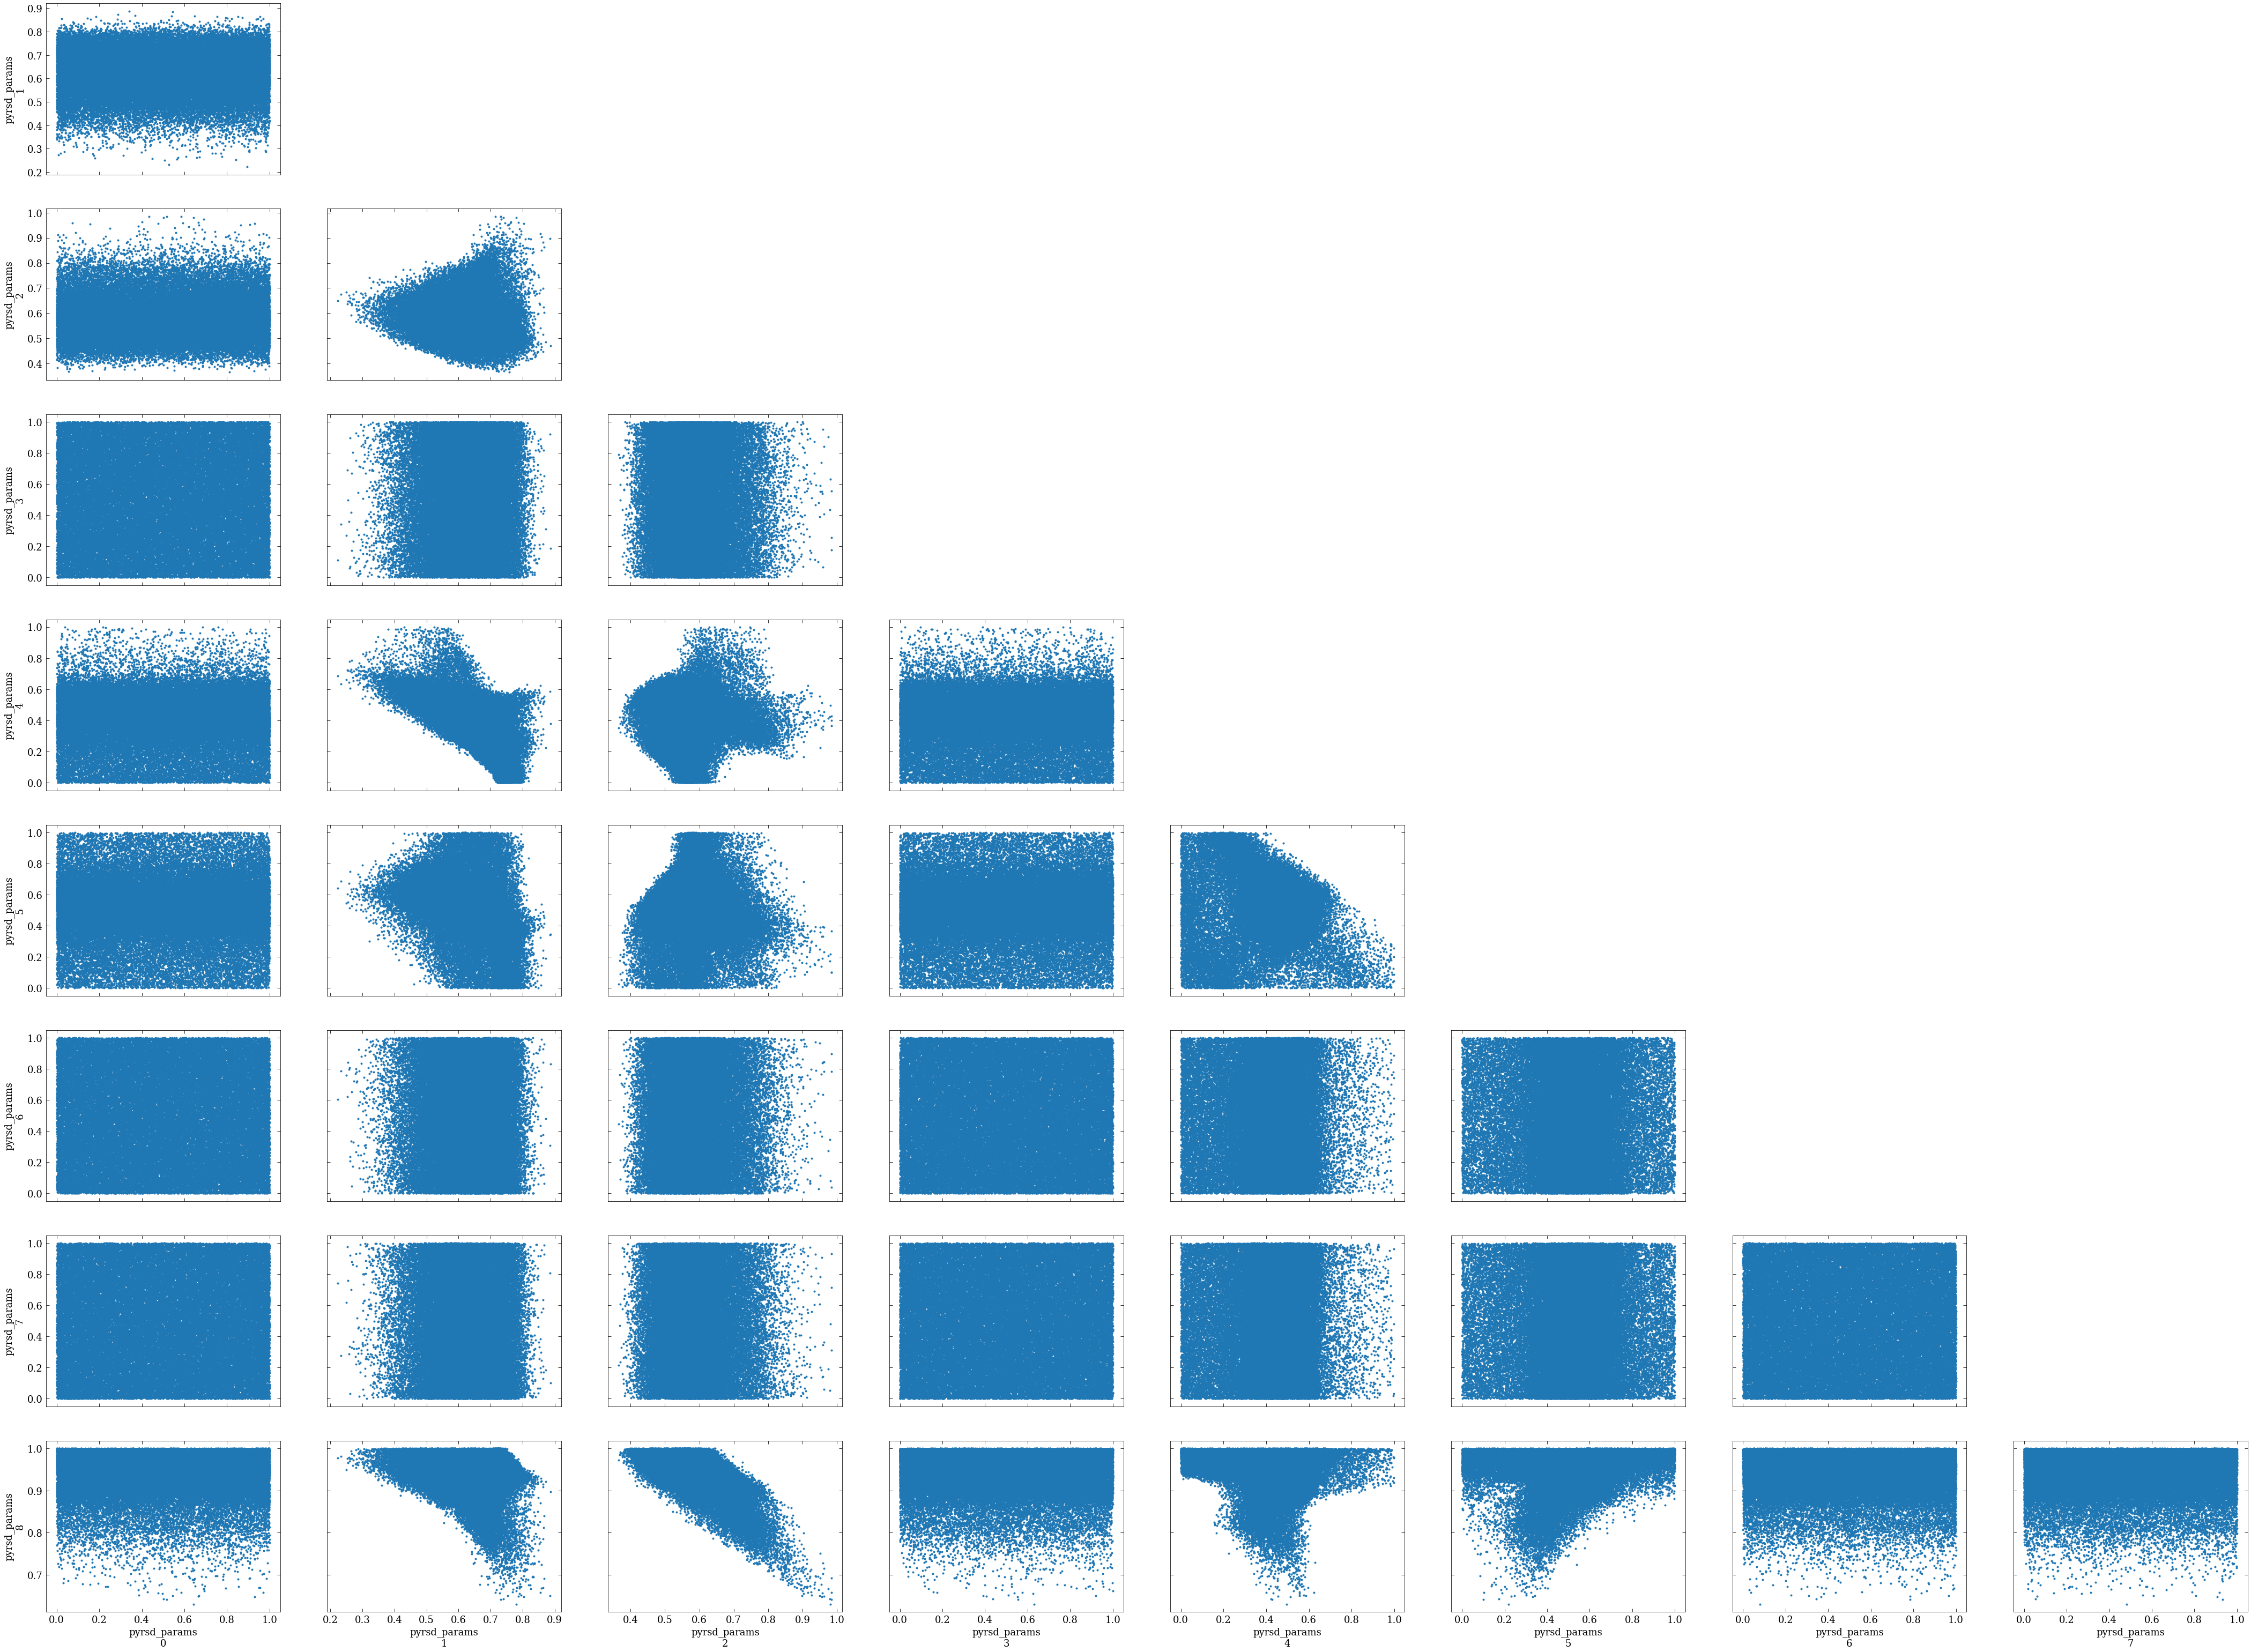

In [11]:
#https://fehiepsi.github.io/rethinking-numpyro/09-markov-chain-monte-carlo.html
import arviz as az

az.plot_pair(az.from_numpyro(mcmc))
plt.show()



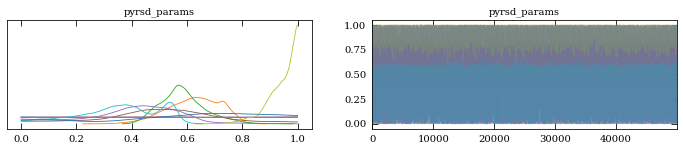

In [12]:
az.plot_trace(az.from_numpyro(mcmc))
plt.show()

[[0.79400873 0.60276335 0.5448832  0.5666928  0.4236548  0.6458941
  0.658348   0.47477382 0.96366274 0.38344154 0.79172504]]

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 pyrsd_params[0]      0.50      0.29      0.50      0.09      1.00  48740.54      1.00
 pyrsd_params[1]      0.62      0.09      0.63      0.48      0.78  14082.10      1.00
 pyrsd_params[2]      0.59      0.08      0.58      0.44      0.71  12256.02      1.00
 pyrsd_params[3]      0.50      0.29      0.50      0.06      0.96  51595.69      1.00
 pyrsd_params[4]      0.41      0.17      0.43      0.08      0.64   9437.50      1.00
 pyrsd_params[5]      0.51      0.20      0.51      0.11      0.83  14601.53      1.00
 pyrsd_params[6]      0.50      0.29      0.50      0.03      0.93  45055.58      1.00
 pyrsd_params[7]      0.50      0.29      0.49      0.09      0.99  50127.10      1.00
 pyrsd_params[8]      0.94      0.05      0.95      0.87      1.00   8403.90      1.00
 py

In [ ]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, HMC

def model_pyro(model_emu, y, y_sig):
    model_emu.eval()
    # with pyro.plate("data", y.shape[0]):
    x_ini = pyro.sample('pyrsd_params', dist.Uniform(torch.zeros(11), torch.ones(11)))
    y_pred = jax_model(x_ini)
    return numpyro.sample('obs', dist.Normal(y_pred, y_sig), obs=y)

params = {}
params['num_samples'] = 5
params['num_chains'] = 1
params['warmup_steps'] = 5
params['num_steps'] = 3

params['jit'] = False

y, y_sig, x = train_dataset.__getitem__(0)
y, y_sig, x = torch.tensor(y), torch.tensor(y_sig), torch.tensor(x)
# y, y_sig, x = torch.tensor(y[None, :]).cuda(), torch.tensor(y_sig[None, :]).cuda(), torch.tensor(x[None, :]).cuda()
print(y.shape, y_sig.shape, x.shape)


hmc_kernel = HMC(model_pyro, num_steps=params['num_steps'])
mcmc = MCMC(
    hmc_kernel,
    num_samples=params['num_samples'],
    warmup_steps=params['warmup_steps'],
    num_chains=params['num_chains'],
)
mcmc.run(model_emu, y, y_sig)
mcmc.get_samples()['pyrsd_params']#.mean(0)  


# FIND MAP

In [29]:
def sample_from_prior(nparams=11):
    samp = np.random.uniform(0, 1, size=nparams).astype(np.float32)
    samp = torch.tensor(samp, requires_grad=True)
    
    return samp

    
def loss(x, sig_x, x_pred, noise_floor=1e-9):

    return torch.sum(
                torch.log(sig_x**2 + noise_floor)/2
                + (x - x_pred)**2/(2*sig_x**2+noise_floor),
            )   

def find_MAP(model, x, x_samp, y, y_sig, niter=25000, learning_rate=0.01, print_every=1000):
    
    model.eval()
    opt = torch.optim.Adam([x_samp], lr=learning_rate)
    for i in range(niter):
        y_pred = model(x_samp)
        loss_val = loss(y, y_sig, y_pred)
        loss_val.backward()
        if i % print_every == 0:
            print(f"Iteration: {i}, Loss: {loss_val.item():0.2f}:")
            # print(x_samp)
        opt.step()
        opt.zero_grad()

    return loss_val.item()
        
y, y_sig, x = train_dataset.__getitem__(0)
# x_samp =  torch.tensor(x.copy(), requires_grad=True) # debug

y, y_sig, x = torch.tensor(y), torch.tensor(y_sig), torch.tensor(x)

n_ini = 1
min_loss = float('inf')

for i in range(n_ini):
    np.random.seed(i+10)
    x_samp = sample_from_prior()
    x_ini_i = x_samp.detach().numpy().copy()

    lossi = find_MAP(model_emu, x, x_samp, y, y_sig)
    x_map_i = x_samp.detach().numpy().copy()

    if lossi < min_loss:
        min_loss = lossi
        x_ini = x_ini_i.copy()
        x_map = x_map_i.copy()
        
    print(x, x_ini_i, x_map_i)
    
print(x_ini, x_samp)

Iteration: 0, Loss: 34686884.00:
Iteration: 1000, Loss: 63575.50:
Iteration: 2000, Loss: 58863.45:
Iteration: 3000, Loss: 50142.11:
Iteration: 4000, Loss: 34124.45:
Iteration: 5000, Loss: 27152.64:
Iteration: 6000, Loss: 27151.20:
Iteration: 7000, Loss: -229.64:
Iteration: 8000, Loss: -899.55:
Iteration: 9000, Loss: -1079.81:
Iteration: 10000, Loss: -1097.51:
Iteration: 11000, Loss: -1052.08:
Iteration: 12000, Loss: -1091.66:
Iteration: 13000, Loss: -1105.05:
Iteration: 14000, Loss: -1052.40:
Iteration: 15000, Loss: -1085.87:
Iteration: 16000, Loss: -1103.66:
Iteration: 17000, Loss: -1030.10:
Iteration: 18000, Loss: -1072.52:
Iteration: 19000, Loss: -1099.71:
Iteration: 20000, Loss: -826.49:
Iteration: 21000, Loss: -1048.23:
Iteration: 22000, Loss: -1094.10:
Iteration: 23000, Loss: -1027.82:
Iteration: 24000, Loss: -1049.96:
tensor([0.7940, 0.6028, 0.5449, 0.5667, 0.4237, 0.6459, 0.6583, 0.4748, 0.9637,
        0.3834, 0.7917]) [0.77132064 0.02075195 0.6336482  0.74880385 0.49850702 0.

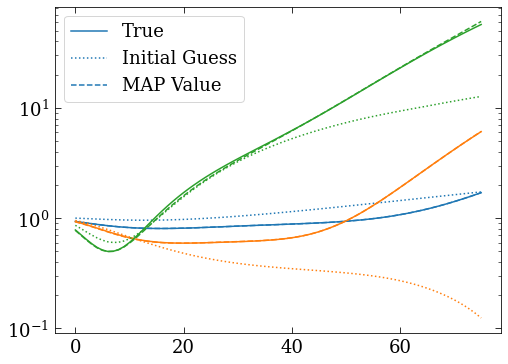

In [30]:
pk_pred_ini = model_emu(torch.tensor(x_ini)).detach().numpy()
pk_pred_map = model_emu(torch.tensor(x_map)).detach().numpy()

pk_pred_ini = pk_pred_ini.reshape(3, -1)
pk_pred_map = pk_pred_map.reshape(3, -1)

lab = None
for i in range(pk.shape[0]):
    if i != 0:
        lab = True
    plt.plot(pk[i], label="True" if not lab else None, color=f"C{i%10}")
    plt.plot(pk_pred_ini[i], ls=":", label="Initial Guess" if not lab else None, color=f"C{i%10}")
    plt.plot(pk_pred_map[i], ls="--", label="MAP Value" if not lab else None, color=f"C{i%10}")

plt.legend()
plt.yscale('log')

tensor([0.7940, 0.6028, 0.5449, 0.5667, 0.4237, 0.6459, 0.6583, 0.4748, 0.9637,
        0.3834, 0.7917]) [-3.921648    0.7064193   0.6518571  -0.6361042   0.35377085  0.76799273
  1.3846014   1.7818698   0.8593256   0.43779325  1.1710364 ]


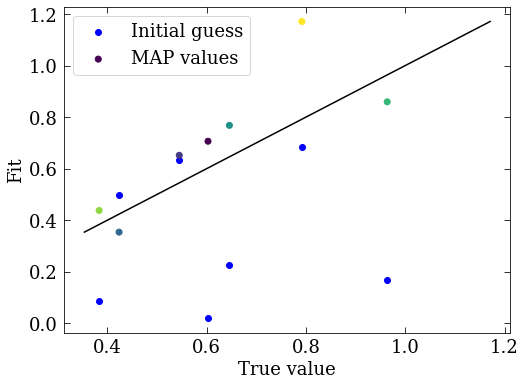

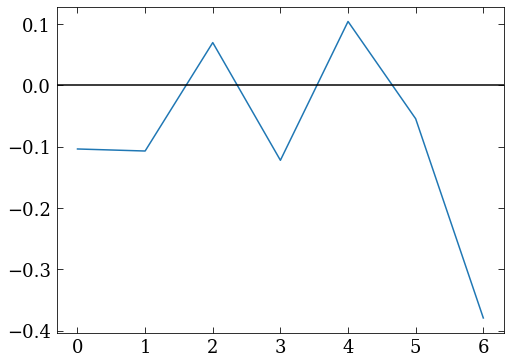

In [31]:
print(x, x_map)
useful_param_inds = [1,2,4,5,8,9,10]
xy_min, xy_max = min(x[useful_param_inds].min(), x_map[useful_param_inds].min()), max(x[useful_param_inds].max(), x_map[useful_param_inds].max())

plt.figure()
plt.scatter(x[useful_param_inds], x_ini[useful_param_inds], color='b', label='Initial guess')
plt.scatter(x[useful_param_inds], x_map[useful_param_inds], c=np.arange(x[useful_param_inds].shape[0]), label='MAP values')
plt.plot([xy_min, xy_max], [xy_min, xy_max], color='k')
plt.xlabel("True value")
plt.ylabel("Fit")
plt.legend()

plt.figure()
# plt.plot((x-x_map))
plt.plot((x-x_map)[useful_param_inds])
plt.axhline(0, color='k')

## Pyro trials

In [30]:
true_coefs = torch.tensor([1., 2., 3.])
data = torch.randn(2000, 3)
dim = 3
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()
def model_pyro(data):
    coefs_mean = torch.zeros(dim)
    coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))
    y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
    return y
hmc_kernel = HMC(model_pyro, step_size=0.0855, num_steps=4)
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100)
mcmc.run(data)
mcmc.get_samples()['beta'].mean(0)  


Sample: 100%|██████████| 600/600 [00:01, 533.66it/s, step size=4.24e-01, acc. prob=0.966]


tensor([1.0680, 2.0676, 3.0148])

In [33]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, HMC

def model_pyro(model_emu, y, y_sig):
    model_emu.eval()
    # with pyro.plate("data", y.shape[0]):
    x_ini = pyro.sample('pyrsd_params', dist.Uniform(torch.zeros(11), torch.ones(11)))
    y_pred = model_emu(x_ini)
    return pyro.sample('obs', dist.Normal(y_pred, y_sig), obs=y)

params = {}
params['num_samples'] = 5
params['num_chains'] = 1
params['warmup_steps'] = 5
params['num_steps'] = 3

params['jit'] = False

y, y_sig, x = train_dataset.__getitem__(0)
y, y_sig, x = torch.tensor(y), torch.tensor(y_sig), torch.tensor(x)
# y, y_sig, x = torch.tensor(y[None, :]).cuda(), torch.tensor(y_sig[None, :]).cuda(), torch.tensor(x[None, :]).cuda()
print(y.shape, y_sig.shape, x.shape)


hmc_kernel = HMC(model_pyro, num_steps=params['num_steps'])
mcmc = MCMC(
    hmc_kernel,
    num_samples=params['num_samples'],
    warmup_steps=params['warmup_steps'],
    num_chains=params['num_chains'],
)
mcmc.run(model_emu, y, y_sig)
mcmc.get_samples()['pyrsd_params']#.mean(0)  


torch.Size([228]) torch.Size([228]) torch.Size([11])


Warmup:   0%|          | 0/10 [00:00, ?it/s]

KeyboardInterrupt: 

In [107]:
import jax.numpy as jnp


ModuleNotFoundError: No module named 'jax'

0
2
4
6
4
mlp.0.weight tensor([[ 0.1594, -0.1928, -0.3025,  ..., -0.0074, -0.1346, -0.0039],
        [-0.0672, -0.8292,  0.0057,  ..., -0.8951,  0.1631, -0.2366],
        [-0.0946, -0.1376,  0.1784,  ..., -0.0986, -0.1338, -0.2662],
        ...,
        [-0.1102,  0.0611, -0.1970,  ..., -0.2304,  0.1283, -0.2638],
        [-0.1677, -0.5654, -0.2078,  ..., -0.2081, -0.1667, -0.0519],
        [-0.1575, -1.6564, -0.1950,  ..., -0.8106,  0.0881, -0.5124]],
       device='cuda:0')
mlp.0.bias tensor([-0.1809, -0.0086, -0.2179,  1.1881,  0.2404, -1.3355,  0.4042, -1.6604,
        -0.5934, -1.2849, -0.2165,  0.8485,  0.0106, -0.2683, -0.1826,  0.2803,
         0.0415, -0.1036, -0.0056, -0.8652, -1.2484, -0.1315, -0.4303, -0.2251,
        -0.4053, -0.2626, -0.4875, -0.3817, -0.1512, -0.2960,  1.3401, -0.3014,
        -0.5776,  0.8537, -0.1318,  0.2587,  1.1832, -0.2105,  0.7916, -0.2288,
        -0.1693,  1.1548, -0.8976,  0.0656, -0.2266, -0.2359, -0.2295, -0.4357,
        -0.8855,  1.4813,  0

In [68]:
model_emu.device, x.device, y.device, y_sig.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

Warmup:   2%|▏         | 3/200 [09:03, 181.26s/it, step size=5.58e-06, acc. prob=0.000]

tensor([ 0.9339,  0.9200,  0.9055,  0.8917,  0.8781,  0.8659,  0.8544,  0.8445,
         0.8354,  0.8277,  0.8214,  0.8161,  0.8118,  0.8090,  0.8071,  0.8060,
         0.8055,  0.8061,  0.8075,  0.8092,  0.8114,  0.8138,  0.8168,  0.8205,
         0.8241,  0.8277,  0.8314,  0.8351,  0.8389,  0.8430,  0.8470,  0.8510,
         0.8548,  0.8586,  0.8622,  0.8657,  0.8692,  0.8729,  0.8768,  0.8806,
         0.8844,  0.8883,  0.8923,  0.8965,  0.9009,  0.9057,  0.9108,  0.9165,
         0.9228,  0.9298,  0.9374,  0.9459,  0.9552,  0.9655,  0.9770,  0.9895,
         1.0034,  1.0187,  1.0356,  1.0542,  1.0747,  1.0972,  1.1219,  1.1488,
         1.1781,  1.2099,  1.2445,  1.2818,  1.3221,  1.3656,  1.4124,  1.4628,
         1.5169,  1.5747,  1.6366,  1.7026,  0.9297,  0.9016,  0.8722,  0.8426,
         0.8123,  0.7833,  0.7552,  0.7293,  0.7053,  0.6838,  0.6650,  0.6486,
         0.6346,  0.6235,  0.6143,  0.6070,  0.6015,  0.5977,  0.5953,  0.5940,
         0.5936,  0.5939,  0.5949,  0.59


/global/homes/g/gstein/.conda/envs/pyrsd_emu/lib/python3.9/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs
  warnings.warn(


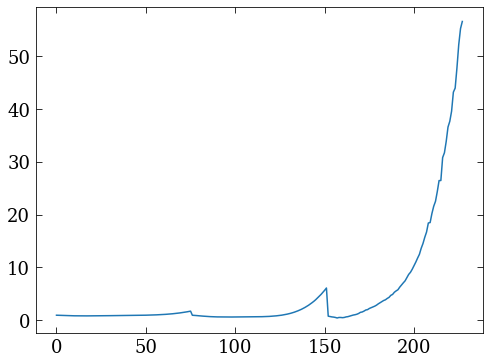

In [59]:
plt.plot(dist.Normal(y, y_sig).sample().numpy())

x_ini = pyro.sample('pyrsd_params', dist.Uniform(torch.zeros(11), torch.ones(11)))
y_pred = model_emu(x_ini)
out = pyro.sample('obs', dist.Normal(y_pred, y_sig), obs=y)
print(out)

In [16]:
import argparse
import logging

import data
import torch

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, HMC


def model(sigma):
    eta = pyro.sample("eta", dist.Normal(torch.zeros(data.J), torch.ones(data.J)))
    mu = pyro.sample("mu", dist.Normal(torch.zeros(1), 10 * torch.ones(1)))
    tau = pyro.sample("tau", dist.HalfCauchy(scale=25 * torch.ones(1)))

    theta = mu + tau * eta

    return pyro.sample("obs", dist.Normal(theta, sigma))


def conditioned_model(model, sigma, y):
    return poutine.condition(model, data={"obs": y})(sigma)


def main(params):
    nuts_kernel = NUTS(conditioned_model, jit_compile=params['jit'])
    mcmc = MCMC(
        nuts_kernel,
        num_samples=params['num_samples'],
        warmup_steps=params['warmup_steps'],
        num_chains=params['num_chains'],
    )
    mcmc.run(model, data.sigma, data.y)
    mcmc.summary(prob=0.5)


assert pyro.__version__.startswith("1.8.1")
params = {}
params['num_samples'] = 100
params['num_chains'] = 1
params['warmup_steps'] = 100
params['jit'] = False

main(params)

AttributeError: module 'data' has no attribute 'sigma'

In [19]:
true_coefs = torch.tensor([1., 2., 3.])
data = torch.randn(2000, 3)
dim = 3
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()
def model(data):
    coefs_mean = torch.zeros(dim)
    coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))
    y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
    return y
hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100)
mcmc.run(data)
mcmc.get_samples()['beta'].mean(0)  


Sample: 100%|██████████| 600/600 [00:01, 573.48it/s, step size=5.89e-01, acc. prob=0.934]


tensor([1.0377, 1.9219, 3.0973])

In [13]:
true_coefs = torch.tensor([1., 2., 3.])
data = torch.randn(2000, 3)
dim = 3
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()
def model(data):
    coefs_mean = torch.zeros(dim)
    coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))
    y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
    return y
hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=100)
mcmc.run(data)
mcmc.get_samples()['beta'].mean(0)  


Type:        module
String form: <module 'data' (namespace)>
Docstring:   <no docstring>


In [7]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1594, -0.1928, -0.3025,  ..., -0.0074, -0.1346, -0.0039],
        [-0.0672, -0.8292,  0.0057,  ..., -0.8951,  0.1631, -0.2366],
        [-0.0946, -0.1376,  0.1784,  ..., -0.0986, -0.1338, -0.2662],
        ...,
        [-0.1102,  0.0611, -0.1970,  ..., -0.2304,  0.1283, -0.2638],
        [-0.1677, -0.5654, -0.2078,  ..., -0.2081, -0.1667, -0.0519],
        [-0.1575, -1.6564, -0.1950,  ..., -0.8106,  0.0881, -0.5124]],
       requires_grad=True)
Parameter containing:
tensor([-0.1809, -0.0086, -0.2179,  1.1881,  0.2404, -1.3355,  0.4042, -1.6604,
        -0.5934, -1.2849, -0.2165,  0.8485,  0.0106, -0.2683, -0.1826,  0.2803,
         0.0415, -0.1036, -0.0056, -0.8652, -1.2484, -0.1315, -0.4303, -0.2251,
        -0.4053, -0.2626, -0.4875, -0.3817, -0.1512, -0.2960,  1.3401, -0.3014,
        -0.5776,  0.8537, -0.1318,  0.2587,  1.1832, -0.2105,  0.7916, -0.2288,
        -0.1693,  1.1548, -0.8976,  0.0656, -0.2266, -0.2359, -0.2295, -0.4357,
        -0.8855

(1000, 228)


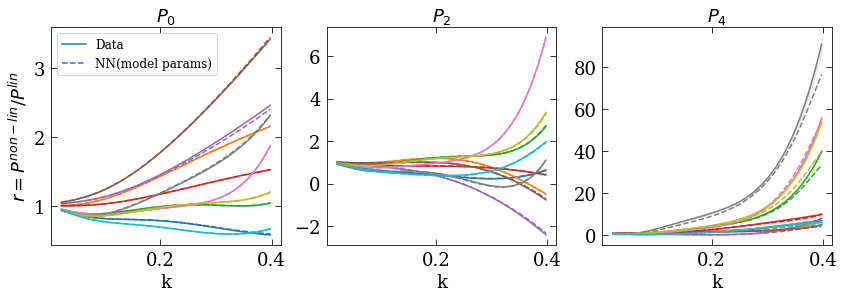

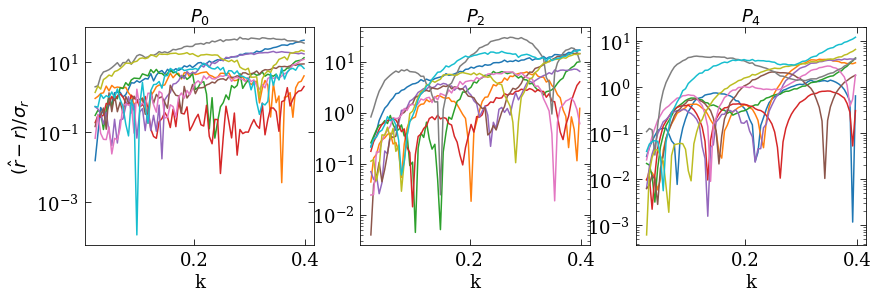

In [104]:
model.eval()

nuse = 1000
nplt = 10
    
pk_r = model(torch.tensor(model_params[:nuse])).detach().numpy()
print(pk_r.shape)
#     plt.figure(figsize=(12,8))
#     for i in range(nuse):
#         plt.plot(k, pk[i], color=f"C{i%10}")
#         plt.plot(k, pk_r[i], color=f"C{i%10}", ls="--")

#     plt.xlabel('k')
#     plt.ylabel('P(k)')


#     fig, ax = plt.subplots(1, 2, figsize=(12,4))


fig, ax = plt.subplots(1, max(multipole_order, 2), figsize=(14,4))
for i in range(nplt):
    for j in range(multipole_order):
        lab = lab_r = None
        if i==0 and j ==0:
            lab = 'Data'
            lab_r = 'NN(model params)'
        ax[j].plot(k[:76*multipole_order], pk.reshape(pk.shape[0], multipole_order, -1)[i,j], color=f"C{i%10}", ls='-', label=lab)
        ax[j].fill_between(
            k[:76*multipole_order],
            pk.reshape(pk.shape[0], multipole_order, -1)[i,j] - pk_sig.reshape(pk.shape[0], multipole_order, -1)[i,j],
            pk.reshape(pk.shape[0], multipole_order, -1)[i,j] + pk_sig.reshape(pk.shape[0], multipole_order, -1)[i,j],
            color=f"C{i%10}", alpha=0.1)
        
        ax[j].plot(k[:76*multipole_order], pk_r.reshape(pk_r.shape[0], multipole_order, -1)[i,j], color=f"C{i%10}", ls='--', label=lab_r)

ax[0].legend(loc='upper left', fontsize=12)

for i, axi in enumerate(ax):
    axi.set_xlabel('k')
    axi.set_title(f"$P_{i*2}$")

ax[0].set_ylabel('$r=P^{non-lin}/P^{lin}$')
# ax[2].set_yscale('log')
plt.savefig("../figures/model_params_to_pk.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1, max(multipole_order, 2), figsize=(14,4))
for i in range(nplt):
    for j in range(multipole_order):
        # diff = pk_r.reshape(pk_r.shape[0], 3, -1)[i,j] - pk.reshape(pk.shape[0], 3, -1)[i,j]
        # diff /= pk_sig.reshape(pk_sig.shape[0], multipole_order, -1)[i,j]
        
        diff = pk_r.reshape(pk_r.shape[0], multipole_order, -1)[i,j] - pk.reshape(pk.shape[0], multipole_order, -1)[i,j]
        diff /= pk_sig.reshape(pk_sig.shape[0], multipole_order, -1)[i,j]
        diff = np.abs(diff)
        
        ax[j].plot(
            k[:76*multipole_order],
            diff,
            color=f"C{i%10}", ls='-')
        # ax[j].fill_between(
        #     k,
        #     diff - pk_sig.reshape(pk_sig.shape[0], multipole_order, -1)[i,j],
        #     diff + pk_sig.reshape(pk_sig.shape[0], multipole_order, -1)[i,j],
        #     color=f"C{i%10}", alpha=0.1)

for i, axi in enumerate(ax):
    axi.set_xlabel('k')
    axi.set_title(f"$P_{i*2}$")
    # axi.set_ylim(0, 10)
    axi.set_yscale('log')
    
ax[0].set_ylabel('$(\hat{r} - r)/ \sigma_r$')

plt.savefig("../figures/model_params_to_pk_ratio.pdf", bbox_inches='tight')


[[0.46660897 0.3530277  0.16024502 ... 0.9302262  0.74115777 0.5950335 ]
 [0.63659406 0.90938133 0.2216898  ... 0.22044407 0.2896042  0.05996545]
 [0.32844204 0.90307057 0.23426594 ... 0.6731466  0.05667082 0.8855    ]
 ...
 [0.8277694  0.29508913 0.27120608 ... 0.5358927  0.17902815 0.28604683]
 [0.53711295 0.51060176 0.31523216 ... 0.6032746  0.5562586  0.09059609]
 [0.44868287 0.14696103 0.9303141  ... 0.55028456 0.3661327  0.55790585]]


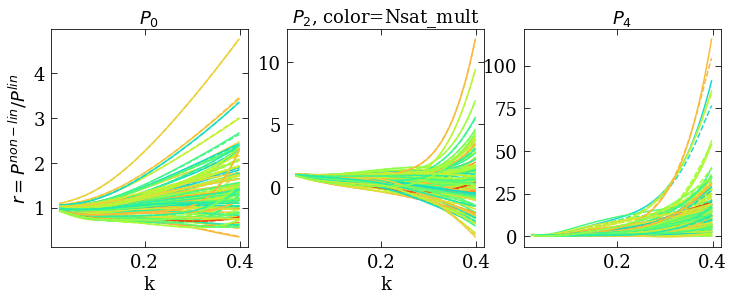

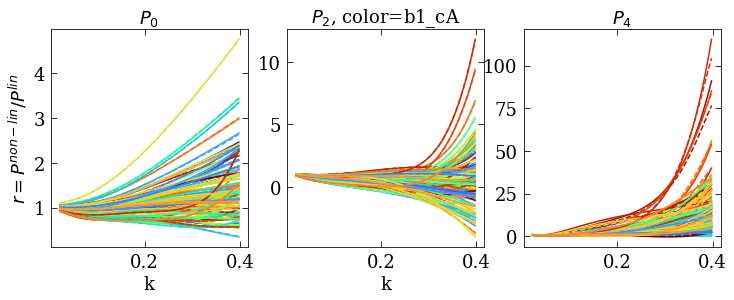

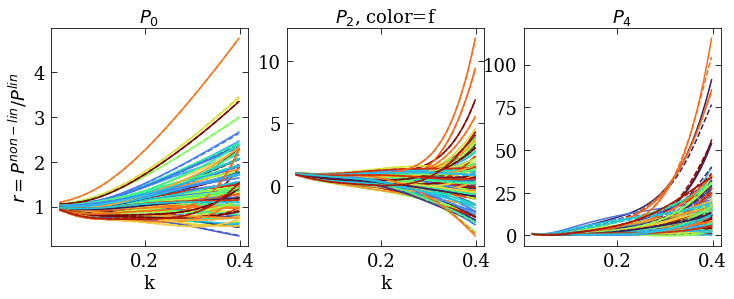

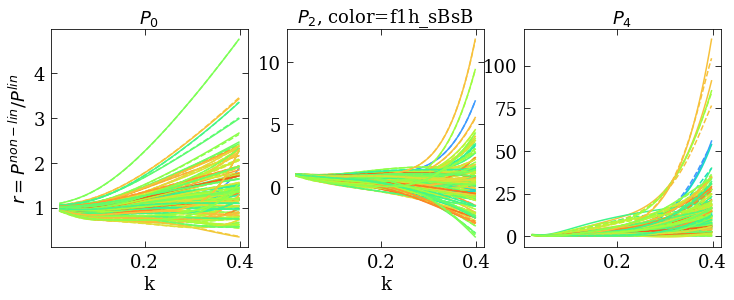

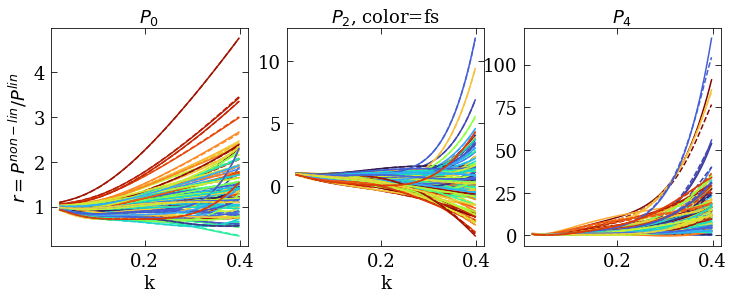

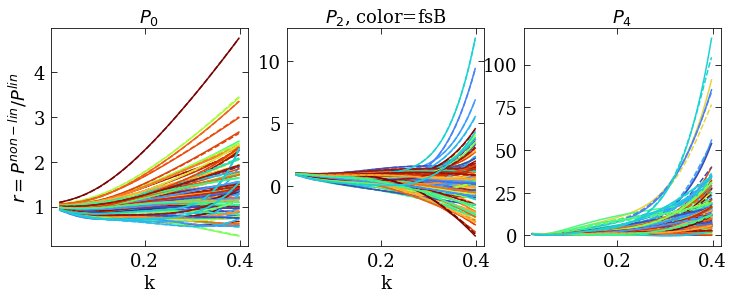

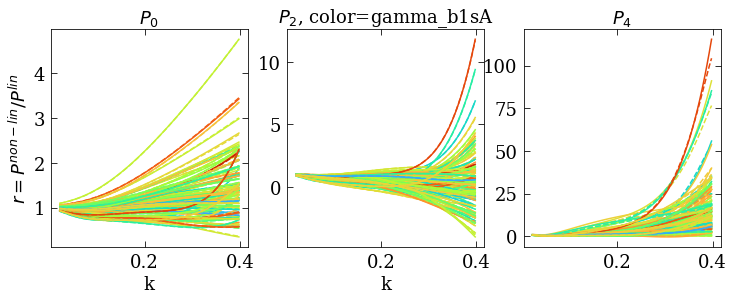

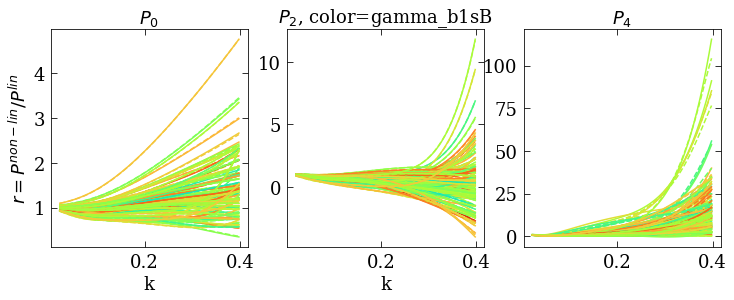

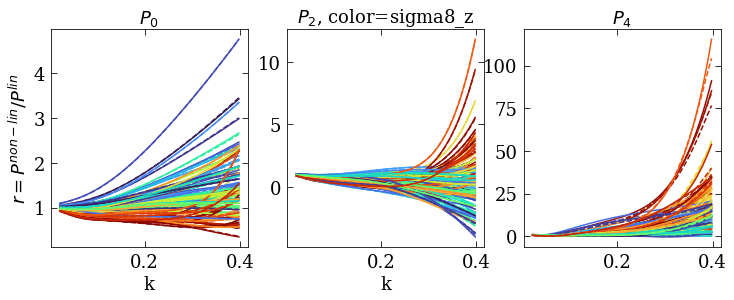

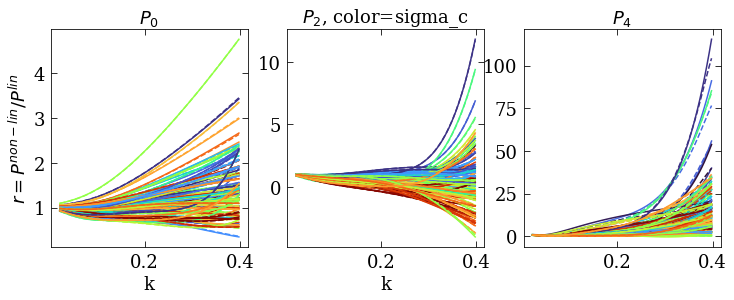

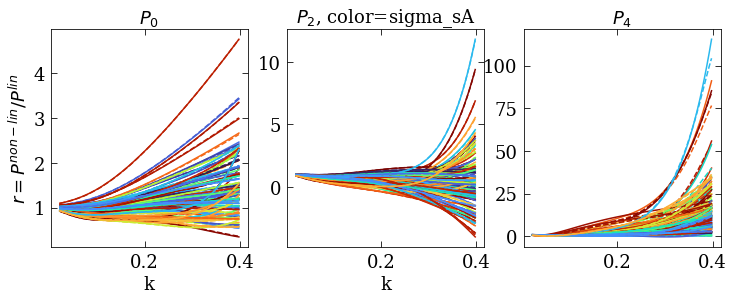

In [105]:
print(model_params)
nplt = 100
cmap = plt.cm.turbo
# for i in range(model_params.shape[1]):
#     plt.figure(figsize=(10,6))
#     cmin, cmax = model_params[:, i].min(), model_params[:, i].max()

#     for j in range(100):
#         c = (model_params[j,i] - cmin)/(cmax+cmin)
#         plt.plot(k, pk[j], color=cmap(c))
        
for i in range(model_params.shape[1]):

    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    cmin, cmax = model_params[:, i].min(), model_params[:, i].max()

    for j in range(nplt):
        c = (model_params[j,i] - cmin)/(cmax-cmin)
        
        for jj in range(3):
            # diff = pk_r.reshape(pk_r.shape[0], 3, -1)[i,j] - pk.reshape(pk.shape[0], 3, -1)[i,j]
            # ax[j].plot(
            #     k,
            #     diff,
            #     color=f"C{i%10}", ls='-')
            # ax[j].fill_between(
            #     k,
            #     diff - pk_sig.reshape(pk_sig.shape[0], 3, -1)[i,j],
            #     diff + pk_sig.reshape(pk_sig.shape[0], 3, -1)[i,j],
            #     color=f"C{i%10}", alpha=0.1)

            ax[jj].plot(k, pk.reshape(pk.shape[0], 3, -1)[j,jj], color=cmap(c), ls='-')
            ax[jj].plot(k, pk_r.reshape(pk_r.shape[0], 3, -1)[j,jj], color=cmap(c), ls='--')

        # ax[1].plot(k, pk[j, nkbins:], color=cmap(c), ls='-')
        # ax[1].plot(k, pk_r[j, nkbins:], color=cmap(c), ls='--')


    ax[0].set_xlabel('k')
    ax[1].set_xlabel('k')
    ax[0].set_ylabel('$r=P^{non-lin}/P^{lin}$')

    ax[0].set_title(f"$P_0$")
    ax[1].set_title(f"$P_2$, color={model_param_names[i]}")
    ax[2].set_title(f"$P_4$")
    
    

# Vary parameters from average

[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]
[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]
[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]
[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]
[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]
[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]
[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]
[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]


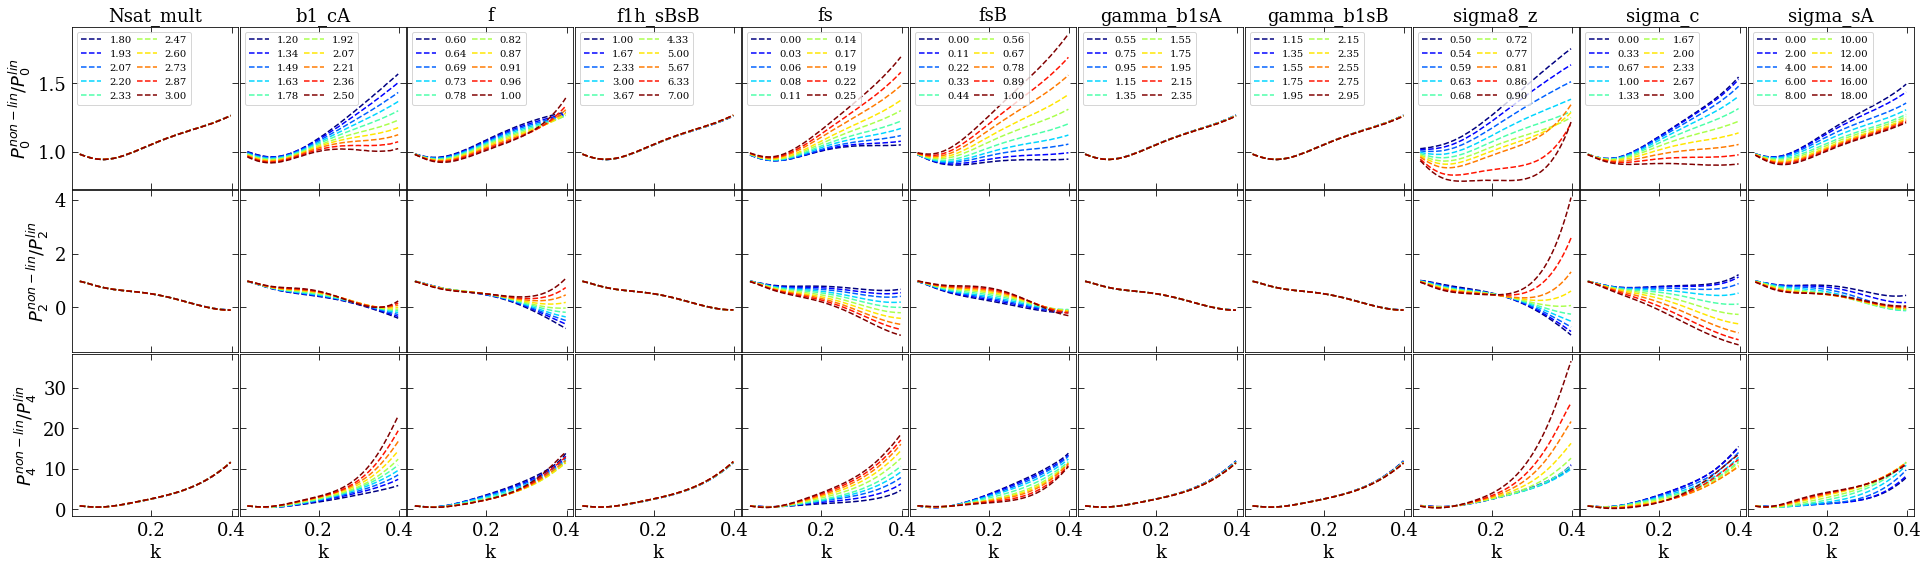

In [106]:
model_params_mean = np.mean(model_params, axis=0)

nplt = 10

cmap = plt.cm.jet

param_val_vary = np.linspace(0, 1, nplt)

nx = model_params_mean.shape[0]
ny = max(multipole_order, 2)

fig, ax = plt.subplots(ny, nx, figsize=(3*nx,3*ny), sharex='col', sharey='row')
plt.subplots_adjust(hspace=0.01, wspace=0.01)
for iparam in range(model_params_mean.shape[0]):
    paramsi = np.tile(model_params_mean, (nplt, 1))
    paramsi[:, iparam] = param_val_vary
    paramsi_print = normalize_model_params(paramsi.copy(), model_param_names, inverse=True)

    pk_r = model(torch.tensor(paramsi)).detach().numpy()
    
    for j in range(multipole_order):    
        lab = None

        for i in range(nplt):
            c = param_val_vary[i]
            if j==0:
                lab = f'{paramsi_print[i, iparam]:.2f}'

            ax[j, iparam].plot(k, pk_r.reshape(pk_r.shape[0], multipole_order, -1)[i,j], color=cmap(c), ls='--', label=lab)

    ax[0, iparam].legend(loc='upper left', ncol=2, fontsize=10, columnspacing=0.5)
    # if iparam == 0:
   
    ax[0, iparam].set_title(model_param_names[iparam])
    ax[2, iparam].set_xlabel('k')
    
ax[0,0].set_ylabel(f"$P_0^{{non-lin}}/P_0^{{lin}}$")
ax[1,0].set_ylabel(f"$P_2^{{non-lin}}/P_2^{{lin}}$")
ax[2,0].set_ylabel(f"$P_4^{{non-lin}}/P_4^{{lin}}$")

#     ax[0].set_ylabel('$r=P^{non-lin}/P^{lin}$')
plt.savefig("../figures/pk_vary_model_params.pdf", bbox_inches='tight')

In [92]:
normalize_model_params(model_params_mean, model_param_names, inverse=True)
model_param_names

[1.8  1.2  0.6  1.   0.   0.   0.55 1.15 0.5  0.   0.  ] [ 3.    2.5   1.    7.    0.25  1.    2.35  2.95  0.9   3.   18.  ]


array(['Nsat_mult', 'b1_cA', 'f', 'f1h_sBsB', 'fs', 'fsB', 'gamma_b1sA',
       'gamma_b1sB', 'sigma8_z', 'sigma_c', 'sigma_sA'], dtype='<U10')

In [ ]:
plt.scatter(model_params[:,0], model_params[:,1], c=pk[:, -1])

plt.figure()
plt.scatter(model_params[:,1], model_params[:,2], c=pk[:, -1])


In [108]:
from pytorch_lightning import loggers as pl_loggers
pl.seed_everything(13579)

multipole_order = 3

params = {}
# params['data_path'] = '../data/powerspectra.h5'
params['train_path'] = '../data/powerspectra_11param_train.h5'
params['val_path'] = '../data/powerspectra_11param_val.h5'
params['max_epochs'] = 25
params['batch_size'] = 32
params['num_workers'] = 4

params['input_dim'] = 76*multipole_order
params['hidden_dims'] = [128, 128, 128, 128]

params['T_max'] = 100
params['learning_rate'] = 0.0005
params['optimizer'] = 'Adam'

params['output_dim'] = 11
params['cosmo_to_pk'] = False

model = MLP(params)

datamodule = PowerspectraDataModule(params)

lr_monitor = pl.callbacks.LearningRateMonitor(
    logging_interval='epoch',
)

tb_logger = pl_loggers.TensorBoardLogger(
    save_dir='logs',
    name='mlp_pk_to_cosmo',
)

trainer = pl.Trainer(
    max_epochs=params['max_epochs'],
    check_val_every_n_epoch=1,
    callbacks=[lr_monitor],
    # strategy="ddp_spawn",
    logger=tb_logger,
    gpus=1,
)

trainer.fit(
    model,
    datamodule=datamodule,
)

Global seed set to 13579
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 80.3 K
------------------------------------
80.3 K    Trainable params
0         Non-trainable params
80.3 K    Total params
0.321     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13579


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

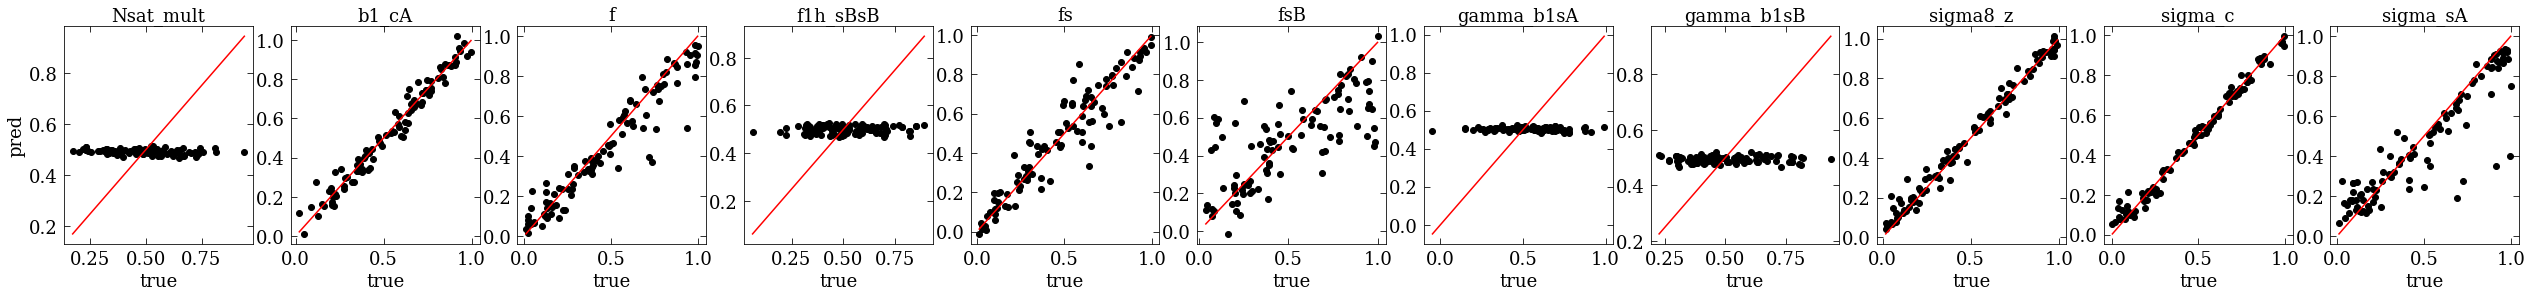

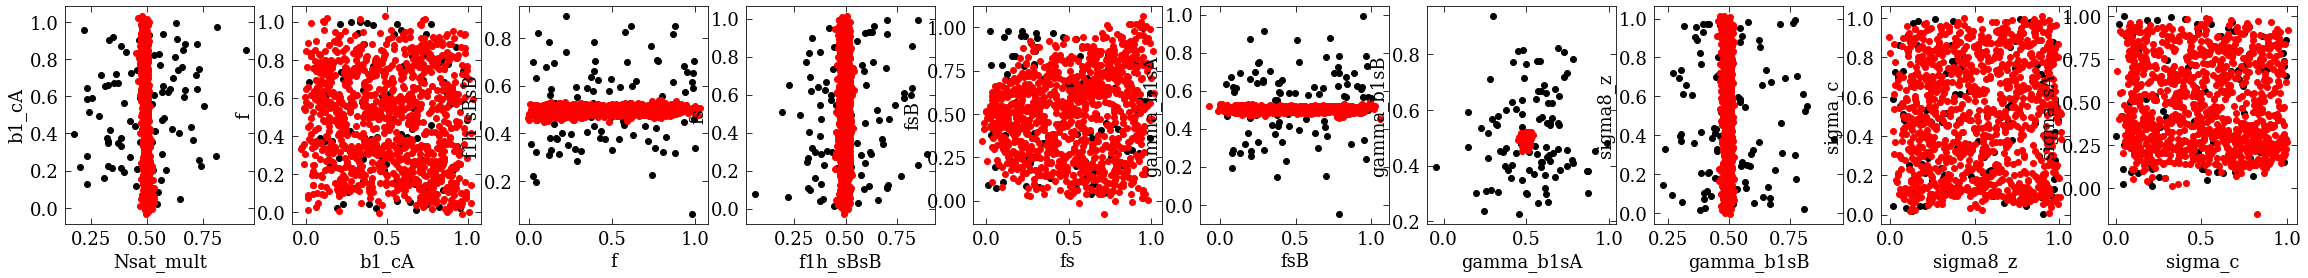

In [109]:
model_params_pred =  model(torch.tensor(pk[:nuse])).detach().numpy()
nplt = 100

fig, ax = plt.subplots(1, model_params.shape[1], figsize=(4*model_params.shape[1],4))
for i in range(model_params.shape[1]):
    ax[i].scatter(model_params[:nplt, i], model_params_pred[:nplt, i], color='k')
    
    xx = np.linspace(model_params[:nplt, i].min(), model_params[:nplt, i].max(), 100)
    ax[i].plot(xx, xx, color="r")

    ax[i].set_title(f"{model_param_names[i]}")
    ax[i].set_xlabel("true")
    if i == 0:
        ax[i].set_ylabel("pred")

plt.savefig("pk_to_param_scatterplots.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1, model_params.shape[1]-1, figsize=(4*(model_params.shape[1]-1),4))
for i in range(model_params.shape[1]-1):
    ax[i].scatter(model_params[:nplt, i], model_params[:nplt, i+1], color='k')
    ax[i].scatter(model_params_pred[:, i], model_params_pred[:, i+1], color='r')
    ax[i].set_xlabel(f"{model_param_names[i]}")
    ax[i].set_ylabel(f"{model_param_names[i+1]}")


In [78]:
model

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)